------------------------
**COMMAND LINE PROCESSING**

In [1]:
# check whether we're running in Jupyter or from a script file
cmd_args = []
import socket
machine = socket.gethostname()
print('Running on machine %s' % machine)

import sys
import os
from copy import copy
from shutil import rmtree # remove a directory recursively
import tarfile
import __main__
in_script = hasattr(__main__, '__file__')
if in_script:
    print("Running paper1_dashboard in command line mode.", flush=True)
    if len(sys.argv) == 1: # print usage instructions
        print('''Usage of paper1_dashboard:
            > to process a dashboard for a single file:
                python paper1_dashboard.py -dashboard <datapath with joined_vtk folder>
            > to process a comparison dashboard:
                python paper1_dashboard.py -comparison <datapath with joined_vtk folder> <datapath with joined_vtk folder>
            > to perform an experiment regarding long-term Fsyn enhancement (see Pjanka et al. 2022)
                python paper1_dashboard.py -expLongFsyn <datapath with joined_vtk folder for 1D case> <datapath with joined_vtk folder for 2D (corrugated) case>
            > to process and plot magnetic field curvature diagnostics
                python paper1_dashboard.py -curvature <datapath with joined_vtk folder>
            > other options
                -nproc - number of threads for parallel processing
                -opt_tf <0/1> - turn off/on tensorflow parallelization
                -opt_numba <0/1> - turn off/on numba optimization
                -low_memory <0/1> - make adjustments to enable computing with low system memory available
                -convert_vtk <0/1> - convert vtk files to .pkl
                -tar_when_done <0/1> - if not already tarfiles, the datapath folders will be turned into *.tgz after the analysis is done
                -force_recalc <0/1> - force recalculation from .vtk files even if suitable pre-calculated .pkl files are present''')
        sys.exit()
    cmd_args = sys.argv[1:]
    
# cast anything to bool, including strings
def boolean (x):
    return bool(int(x))
    
def get_arg (argname, n_read=1, default=None, val_type=str):
    try:
        idx = cmd_args.index('-'+argname)
        if n_read == 1:
            return val_type(cmd_args[idx+1])
        else:
            return [val_type[i](cmd_args[idx+1+i]) for i in range(n_read)]
    except Exception as e:
        if default != None:
            return default
        else:
            print('Argument %s not specified, with no default value given. Aborting.' % argname, flush=True)
            sys.exit()

Running on machine ppjanka-razer


------------------------
**EXECUTION SETUP**

In [2]:
# NOTE: Throughout this work, Bfield is defined such that U_B = B**2/2, unless stated otherwise

# PROCESSING TYPE
if '-dashboard' in cmd_args:
    processing_type = 'dashboard'
    datapath = get_arg('dashboard')
    if '.tgz' not in datapath and datapath[-1] != '/':
        datapath += '/'
elif '-comparison' in cmd_args:
    processing_type = 'comparison'
    datapaths_comp = list(get_arg('comparison', n_read=2, val_type=[str,str]))
    for i in range(2):
        if '.tgz' not in datapaths_comp[i] and datapaths_comp[i][-1] != '/':
            datapaths_comp[i] += '/'
elif '-expLongFsyn' in cmd_args:
    processing_type = 'expLongFsyn'
    datapaths_comp = list(get_arg('expLongFsyn', n_read=2, val_type=[str,str]))
    for i in range(2):
        if '.tgz' not in datapaths_comp[i] and datapaths_comp[i][-1] != '/':
            datapaths_comp[i] += '/'
elif '-curvature' in cmd_args:
    processing_type = 'curvature'
    datapath = get_arg('curvature')
    if '.tgz' not in datapath and datapath[-1] != '/':
        datapath += '/'
else: # default processing options
    if False:
        processing_type = 'curvature'
        datapath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_corr1ampl20'
        if '.tgz' not in datapath and datapath[-1] != '/':
            datapath += '/'
    elif False:
        processing_type = 'expLongFsyn'
        datapaths_comp = [
            '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/test_corr0_ampl50',
            '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/test_corr1_ampl50'
        ]
        for i in range(2):
            if datapaths_comp[i][-4:] != '.tgz' and datapaths_comp[i][-1] != '/':
                datapaths_comp[i] += '/'
    elif False:
        processing_type = 'dashboard'
        datapath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/test_tf.tgz'
        if '.tgz' not in datapath and datapath[-1] != '/':
            datapath += '/'
    else:
        processing_type = 'comparison'
        datapaths_comp = [
            '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_corr0ampl50',
            '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT2_press/prod1_corr_ampl/results_corr1ampl50'
        ]
        for i in range(2):
            if datapaths_comp[i][-4:] != '.tgz' and datapaths_comp[i][-1] != '/':
                datapaths_comp[i] += '/'

# MAIN EXECUTION PARAMETERS
unit_check = False # turns off optimization but allows to use astropy to check the units
tar_when_done = get_arg('tar_when_done', default=False, val_type=boolean) # if not already a tarfile, datapath will be turned into .tgz at the end of analysis
opt_tf = get_arg('opt_tf', default=False, val_type=boolean) # use tensorflow instead of numpy for GPU acceleration, x5 speedup
opt_numba = get_arg('opt_numba', default=True, val_type=boolean) # use numba to pre-compile some of the functions, about 3x speedup (turned off if opt_tf is on and GPU available)
low_memory = get_arg('low_memory', default=False, val_type=boolean) # make adjustments to enable computing with low system memory available
convert_vtk = get_arg('convert_vtk', default=True, val_type=boolean) # saves vtk and processing data as pkl -- needed to use tensorflow, but also prevents from recalculating the same data
force_recalc = get_arg('force_recalc', default=False, val_type=boolean) # force recalculation of augmented data, even if present in the pkl files

import multiprocessing
cpu_avail = multiprocessing.cpu_count()
nproc = get_arg('nproc', default=int(0.5*cpu_avail), val_type=int)
nproc_history = get_arg('nproc_history', default=1, val_type=int)
if nproc < 0:
    nproc = cpu_avail
if nproc_history < 0:
    nproc_history = cpu_avail
print(f'Using nproc = {nproc}, nproc_history = {nproc_history}', flush=True)

#---------------------------------------------------------------

# optimization logic
opt_tf = (not unit_check and opt_tf)
if opt_tf:
    import tensorflow as tf
    # do not use tensorflow if no or insufficient GPU detected (tf requires compute capability > 3.5), use numba instead
    gpu_list = tf.config.list_physical_devices('GPU')
    # if running on tegner
    if machine[0] == 't' and machine[-11:] == '.pdc.kth.se':
        # only the double-GPU nodes on tegner have sufficient compute capability to use tensorflow
        opt_tf = (len(gpu_list) > 1)
    else:
        # otherwise use tf if any gpu available
        opt_tf = (len(gpu_list) > 0)

opt_numba = (not unit_check and not opt_tf and opt_numba)
opt_fastmath = (opt_numba and True) # 20% speedup, but less precision

# general imports
import glob
import os
from tqdm import tqdm
import numpy as np
import pickle as pkl
from collections.abc import Iterable
from numba import jit, prange

# vtk file loading if available
try:
    import vtk as _
    from read_vtk import vtk
except ImportError:
    def vtk(x, out_dt):
        print('VTK module not available. Please convert to pkl files and use those instead.', flush=True)
        sys.exit()

Using nproc = 6, nproc_history = 1


In [3]:
# tensorflow optimization wrappers
if opt_tf:
    print("Tensorflow %s" % tf.__version__)
    print(gpu_list)
    def tf_convert (*arg):
        '''Convert all arguments to tf.const for GPU processing'''
        return (tf.convert_to_tensor(x, dtype='float64') for x in arg)
    def tf_deconvert (x):
        '''Use tensor.to_numpy() to perform tf operations'''
        return x.numpy()
    where = tf.where
    exp = tf.math.exp
    linspace = tf.linspace
    meshgrid = tf.meshgrid
    npsum = tf.math.reduce_sum
    log = tf.math.log
    reshape = tf.reshape
    sqrt = tf.math.sqrt
    npmax = tf.reduce_max
    def logspace (xmin,xmax,n):
        return 10.**tf.linspace(xmin,xmax,n)
    def log10 (x):
        ten, = tf_convert(10.)
        return tf.math.log(x) / tf.math.log(ten)
    def nansum (x, axis):
        return tf.math.reduce_sum(tf.where(tf.math.is_nan(x),tf.zeros_like(x),x), axis=axis)
    cos = tf.math.cos
    sin = tf.math.sin
    arctan = tf.math.atan
    arccos = tf.math.acos
    modulo = tf.experimental.numpy.mod
    repeat = tf.repeat
    top_k = tf.math.top_k
    expand_dims = tf.expand_dims
    npsort = tf.sort
    nptake = tf.experimental.numpy.take
    nptake_along_axis = tf.experimental.numpy.take_along_axis
    transpose = tf.transpose
    npstack = tf.stack
    swapaxes = tf.experimental.numpy.swapaxes
    moveaxis = tf.experimental.numpy.moveaxis
    npmean = tf.reduce_mean
    npmax = tf.max
else:
    @jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def tf_convert (*arg):
        return arg
    @jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def tf_deconvert (arg):
        return arg
    where = np.where
    exp = np.exp
    linspace = np.linspace
    meshgrid = np.meshgrid
    npsum = np.sum
    log = np.log
    reshape = np.reshape
    sqrt = np.sqrt
    npmax = np.nanmax
    logspace = np.logspace
    log10 = np.log10
    nansum = np.nansum
    cos = np.cos
    sin = np.sin
    arctan = np.arctan
    arccos = np.arccos
    modulo = np.mod
    repeat = np.repeat
    #@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def top_k (x, k):
        return np.argpartition(
            x, k, axis=-1
        )[...,:k]
    expand_dims = np.expand_dims
    npsort = np.sort
    nptake = np.take
    nptake_along_axis = np.take_along_axis
    transpose = np.transpose
    npstack = np.stack
    swapaxes = np.swapaxes
    moveaxis = np.moveaxis
    npmean = np.mean
    npabs = np.abs

In [4]:
# constants
from astropy.constants import e, c, m_e
import astropy.units as u
from scipy.special import gamma
e = e.esu.value * u.cm**1.5 * u.g**0.5 / u.s

if unit_check:
    #units
    cm = u.cm
    gram = u.g
    sec = u.s
    Hz = u.Hz
    kpc = u.kpc
    Msun = u.Msun
    erg = u.erg
    def get_cgs (x): return x.cgs
    def get_cgs_value (x): return x.cgs.value
else:
    #constants
    e = e.cgs.value
    c = c.cgs.value
    m_e = m_e.cgs.value
    #units
    cm = 1.0
    gram = 1.0
    sec = 1.0
    Hz = 1.0
    kpc = (1.*u.kpc).cgs.value
    Msun = (1.*u.Msun).cgs.value
    erg = (1.*u.erg).cgs.value
    @jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def get_cgs (x): return x
    @jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def get_cgs_value (x): return x
    
# simulation units
# anchor points
simu_rho = get_cgs(10**(-15) * gram/cm**3)
simu_t = get_cgs(1.*sec)
simu_len = get_cgs(c*simu_t)
# derivative units
simu_mass = get_cgs(simu_rho * simu_len**3)
simu_en = simu_mass * get_cgs(c)**2 # erg
simu_press = simu_en / simu_len**3 # erg / cm^3
simu_B = np.sqrt(simu_press) # sqrt( erg / cm^3 )
simu_B_8piCorr = np.sqrt(4.*np.pi*simu_press) # sqrt( erg / cm^3 )

--------------------
**PHYSICS**

In [5]:
# PROBLEM PARAMETERS
out_dt_vtk = 0.1
adiab_idx = 1.33333333333

# general parameters, see Malzac (2014,2018)
gmin = 1.0e1
gmax = 1.0e6
p = 2.5
xi_e = 1.0 # electron equipartition parameter, U_e = xi_e* U_B

# choice of emitting region size and frequency for plotting
#R_choice = 6.0e-18 # ensures tau~1 at nu~10^14 (in the IR), it is low due to our high Bfield
R_choice = 6.0e8 # IR core, see Shidatsu et al. (2011)
nu_choice = 1.4e14 # Hz # see Malzac et al. (2018)

# observer-frame frequency range for flux integration
# IR-opt range: 300GHz - 3PHz
nu_int_min = 300.0e9
nu_int_max = 3.0e15

# system properties (see overleaf)
gamma_jet = 2.0
beta_jet = np.sqrt(1.0 - 1.0/gamma_jet**2) # old bug: 0.75
incl = 30.0 * np.pi / 180.
theta_j = 2.3 * np.pi / 180.
dist = 8. * kpc
mbh = 10. * Msun

In [6]:
# MATHS

# vector operations
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def sqr_vec_l2 (x,y,z):
    x,y,z = tf_convert(x,y,z)
    return x**2 + y**2 + z**2
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def norm_vec_l2 (x,y,z):
    x,y,z = tf_convert(x,y,z)
    return sqrt(x**2 + y**2 + z**2)

In [7]:
# SPECIAL RELATIVITY

# NOTE: in Athena 4.2 vel1, vel2, vel3 are 3-velocities. Instead Athena++ uses 4-velocities in the code (so they would need to be translated).

# v <-> gamma convenience functions
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def v2gamma (v):
    v, = tf_convert(v)
    return 1.0/sqrt(1.0-v**2)
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def vsqr2gamma (vsqr):
    vsqr, = tf_convert(vsqr)
    return 1.0/sqrt(1.0-vsqr)

# velocity composition
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def combined_beta_vec (beta_vec):
    '''Combines the fluid beta with the bulk jet motion (general case).'''
    beta_obs = np.zeros(beta_vec.shape)
    beta_obs[...,0] = (beta_vec[...,0] + beta_jet) / (1.0 + beta_vec[...,0]*beta_jet)
    for i in (1, 2):
        beta_obs[...,i] = sqrt(1.0 - beta_jet**2) * beta_vec[...,i] / (1.0 + beta_vec[...,0]*beta_jet)
    return beta_obs
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def combined_beta (beta_vec):
    '''Combines the fluid beta with the bulk jet motion.'''
    beta_vec = combined_beta_vec(beta_vec)
    beta = sqrt(npsum(beta_vec**2, axis=-1))
    return beta_vec, beta
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def combined_gamma (beta_vec):
    '''Combines the fluid beta with the bulk jet motion.'''
    beta_vec, beta = combined_beta(beta_vec)
    gamma = v2gamma(beta)
    return beta_vec, beta, gamma
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def combined_doppler_factor (beta_vec, n_vec):
    '''Combines the fluid beta with the bulk jet motion to get the total doppler factor.'''
    beta_vec, beta, gamma = combined_gamma(beta_vec)
    df = 1.0 / (gamma*(1.0-npsum(beta_vec*n_vec, axis=-1)))
    return beta_vec, beta, gamma, df

# Bcc in the fluid frame
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def BccFl0 (gamma, v1,v2,v3, b1,b2,b3):
    gamma, v1,v2,v3, b1,b2,b3 = tf_convert(gamma, v1,v2,v3, b1,b2,b3)
    return gamma * (v1*b1 + v2*b2 + v3*b3)
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def BccFli (gamma, v,b, bFl0):
    gamma, v,b, bFl0 = tf_convert(gamma, v,b, bFl0)
    return b / gamma + bFl0 * v

In [8]:
# SYNCHROTRON EMISSION

# See Malzac (2014), appendix A

if p != 2.0:
    gamma_e_bar = ((1-p)/(2-p)) * (gmax**(2-p) - gmin**(2-p)) / (gmax**(1-p) - gmin**(1-p))
else:
    gamma_e_bar = (1-p) * np.log(gmax/gmin) / (gmax**(1-p) - gmin**(1-p))

i_gamma = ( gamma_e_bar * (1/(1-p)) * (gmax**(1-p) - gmin**(1-p)) )**(-1)

K_j = ( (np.sqrt(3.) * e**3 * i_gamma) / (16*np.pi**2 * m_e**2 * c**4 * (p+1)) ) \
    * gamma((3*p+19)/12.) * gamma((3*p-1)/12.) * (m_e*c/(3*e))**(-(p-1)/2.)
    
K_a = ( (np.sqrt(3.) * e**3 * i_gamma) / (64*np.pi**2 * m_e**3 * c**4) ) \
    * (3.*e / (2.*np.pi*m_e*c))**(0.5*p) \
    * gamma((3.*p+2)/12.) * gamma((3.*p+22)/12.)
    
# j_nu, nu in fluid frame
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def j_nu (nu_fl, B):
    '''Warning: B is expected in simulation units, and is converted to physical here.
    Unit: g / (cm s**2) = erg / cm**3'''
    nu_fl, B = tf_convert(nu_fl, B*simu_B_8piCorr)
    return get_cgs(K_j * xi_e * (B*(erg/cm**3)**0.5)**((p+5)/2.) * (nu_fl*Hz)**(-(p-1)/2.))
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def alpha_nu (nu_fl, B):
    '''Warning: B is expected in simulation units, and is converted to physical here.
    Unit: 1/cm'''
    nu_fl, B = tf_convert(nu_fl, B*simu_B_8piCorr)
    return get_cgs(K_a * xi_e * (B*(erg/cm**3)**0.5)**(0.5*p+3) * (nu_fl*Hz)**(-(p+4)/2.))
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def j_over_alpha_nu (nu_fl, B):
    '''Warning: B is expected in simulation units, and is converted to physical here.
    Unit: erg / (cm**2)'''
    nu_fl, B = tf_convert(nu_fl, B*simu_B_8piCorr)
    return get_cgs((K_j/K_a) * (B*(erg/cm**3)**0.5)**(-0.5) * (nu_fl*Hz)**(2.5))
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def intensity (nu_fl, B, R):
    '''Warning: B is expected in simulation units.
    Unit: g/s**2 = erg / cm**2'''
    nu_fl, B, R = tf_convert(nu_fl, B, R)
    # for small alphae, we need to use a Taylor expansion
    alpha = alpha_nu(nu_fl,B)
    #return j_nu(nu_fl, B) * R*cm
    return where(
        alpha*R*cm < 1.0e-3,
        j_nu(nu_fl, B) * R*cm,
        j_over_alpha_nu(nu_fl, B) * (1.0-exp(-alpha*R*cm))
    )
    
# observables
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def nu2nu_fl (nu, doppler_factor):
    return nu / doppler_factor
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def flux_nu_per_dS (nu, B, gamma, doppler_factor, R, filling_factor=1.0):
    '''Observer-frame synchrotron flux from the given simulation unit surface.
    Unit: erg / (s cm**2 Hz) / cm**2'''
    nu, B, gamma, doppler_factor, R, filling_factor = tf_convert(nu, B, gamma, doppler_factor, R, filling_factor)
    return (doppler_factor**2 * gamma / (2.*dist**2)) \
             * filling_factor* intensity(nu2nu_fl(nu,doppler_factor),B,R)
             #* (dS*simu_len**2) # perp. surface element, instead of (beta c dt R)
    
if not low_memory:
    # total flux within the IR-opt range: 300GHz - 3PHz
    @jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def _flux_total_integrate (
        nu_grid,B_grid, gamma_grid,df_grid,R,
        dlognu_grid, filling_factor=1.0
    ):
        nu_grid,B_grid,gamma_grid,df_grid,R,dlognu_grid, filling_factor = tf_convert(nu_grid,B_grid,gamma_grid,df_grid,R,dlognu_grid, filling_factor)
        integrand = nu_grid*Hz * get_cgs(flux_nu_per_dS(nu_grid,B_grid,gamma_grid,df_grid,R,filling_factor))
        return npsum(integrand*dlognu_grid, axis=-1)
    # Do NOT use numba for flux_total. It does not understand np.meshgrid, and alternative implementations cause the code to be extremely slow.
    def flux_total_per_dS (B,gamma,df,R, nu_min=nu_int_min, nu_max=nu_int_max, resolution=128, filling_factor=1.0):
        '''Total observer-frame flux from dS within the IR-opt range: 300GHz - 3PHz.
        Unit: erg/(cm**4*sec)'''
        B,gamma,df,R, nu_min,nu_max = tf_convert(B,gamma,df,R, nu_min,nu_max)
        Bshape = B.shape
        # log-integrate the flux
        lognu = linspace(log(nu_min), log(nu_max), resolution)
        dlognu = lognu[1:] - lognu[:-1]
        lognu = 0.5 * (lognu[1:] + lognu[:-1])
        nu = exp(lognu)
        B_grid, nu_grid = meshgrid(B, nu, indexing='ij')
        gamma_grid, dlognu_grid = meshgrid(gamma, dlognu, indexing='ij')
        df_grid, dlognu_grid = meshgrid(df, dlognu, indexing='ij')
        return get_cgs(reshape(_flux_total_integrate(nu_grid,B_grid,gamma_grid,df_grid,R, dlognu_grid, filling_factor), Bshape))
    
else: # low-memory
    @jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def flux_total_per_dS (B,gamma,df,R, nu_min=nu_int_min, nu_max=nu_int_max, resolution=128, filling_factor=1.0):
        '''Total observer-frame flux from dS within the IR-opt range: 300GHz - 3PHz.
        Unit: erg/(cm**4*sec)'''
        B,gamma,df,R, nu_min,nu_max = tf_convert(B,gamma,df,R, nu_min,nu_max)
        Bshape = B.shape
        # log-integrate the flux
        lognu = linspace(log(nu_min), log(nu_max), resolution)
        dlognu = lognu[1:] - lognu[:-1]
        lognu = 0.5 * (lognu[1:] + lognu[:-1])
        nu = exp(lognu)
        result = np.zeros(Bshape)
        for idx in range(len(nu)):
            nu_here = nu[idx]
            dlognu_here = dlognu[idx]
            result += nu_here*Hz * get_cgs(flux_nu_per_dS(nu_here, B, gamma, df, R, filling_factor)) * dlognu_here
        return get_cgs(result)
    
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def syn_emission_rate_per_dS (flux_total_per_dS, doppler_factor, filling_factor=1.0):
    '''Total synchrotron emision rate, averaged over the box surface, observer frame.
    Unit: erg / (cm^2 s)'''
    flux_total_per_dS, doppler_factor = tf_convert(flux_total_per_dS, doppler_factor)
    return (8*np.pi*dist**2 / filling_factor) * npmean(flux_total_per_dS / doppler_factor**3)

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def synEm_per_dnudSdt (nu, B, R, gamma, doppler_factor):
    nu, B, R, gamma, doppler_factor = tf_convert(nu, B, R, gamma, doppler_factor)
    return 4*np.pi * (gamma / doppler_factor) * intensity(nu2nu_fl(nu,doppler_factor), B, R)

if not low_memory:
    @jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def _synEm_integrateNu (nu_grid, dlognu_grid, B_grid, R, gamma_grid, df_grid):
        nu_grid, dlognu_grid, B_grid, R, gamma_grid, df_grid = tf_convert(nu_grid, dlognu_grid, B_grid, R, gamma_grid, df_grid)
        integrand = nu_grid*Hz * get_cgs(synEm_per_dnudSdt(nu_grid,B_grid,R,gamma_grid,df_grid))
        return npsum(integrand*dlognu_grid, axis=-1)
    # Do NOT use numba. It does not understand np.meshgrid, and alternative implementations cause the code to be extremely slow.
    def synEm_per_dSdt (B,gamma,df,R, nu_min=nu_int_min, nu_max=nu_int_max, resolution=128):
        B,gamma,df,R, nu_min,nu_max = tf_convert(B,gamma,df,R, nu_min,nu_max)
        Bshape = B.shape
        # log-integrate the flux
        lognu = linspace(log(nu_min), log(nu_max), resolution)
        dlognu = lognu[1:] - lognu[:-1]
        lognu = 0.5 * (lognu[1:] + lognu[:-1])
        nu = exp(lognu)
        B_grid, nu_grid = meshgrid(B, nu, indexing='ij')
        gamma_grid, dlognu_grid = meshgrid(gamma, dlognu, indexing='ij')
        df_grid, dlognu_grid = meshgrid(df, dlognu, indexing='ij')
        return get_cgs(reshape(
            _synEm_integrateNu (nu_grid, dlognu_grid, B_grid, R, gamma_grid, df_grid),
            Bshape
        ))
    
else: # low-memory
    @jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def synEm_per_dSdt (B,gamma,df,R, nu_min=nu_int_min, nu_max=nu_int_max, resolution=128, filling_factor=1.0):
        B,gamma,df,R, nu_min,nu_max = tf_convert(B,gamma,df,R, nu_min,nu_max)
        Bshape = B.shape
        # log-integrate the flux
        lognu = linspace(log(nu_min), log(nu_max), resolution)
        dlognu = lognu[1:] - lognu[:-1]
        lognu = 0.5 * (lognu[1:] + lognu[:-1])
        nu = exp(lognu)
        result = np.zeros(Bshape)
        for idx in range(len(nu)):
            nu_here = nu[idx]
            dlognu_here = dlognu[idx]
            result += nu_here*Hz * get_cgs(
                synEm_per_dnudSdt (nu_here, B, R, gamma, doppler_factor)
            ) * dlognu_here
        return get_cgs(result)

In [9]:
if unit_check:
    %timeit j_nu(12., 12.)
    print(j_nu(12., 12.))
    print(alpha_nu(12., 12.))
    print(intensity(12., 12.,12.))
    print(flux_total_per_dS(np.array([12.,]),np.array([12.,]),12.,0.5))
    if unit_check:
        print("Check that dimensionless: ", get_cgs(j_over_alpha_nu(12., 12.) / (erg / (cm**2))),
          get_cgs(flux_total(np.array([12.,]),12.,0.5)) / get_cgs(erg/(cm**2*sec)))

In [10]:
# PLASMA PARAMETERS

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def plasma_beta (press, Bflsqr):
    press, Bflsqr = tf_convert(press, Bflsqr)
    return 2.*press / Bflsqr
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def magnetization (Bflsqr, rho):
    Bflsqr, rho = tf_convert(Bflsqr, rho)
    return 0.5 * Bflsqr / rho

# internal energy in the fluid frame, see Beckwith & Stone (2011)
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def enthalpy (adiab_idx, press, rho):
    '''Fluid-frame gas enthalpy per unit mass.'''
    adiab_idx, press, rho = tf_convert(adiab_idx, press, rho)
    return 1.0 + ((adiab_idx)/(adiab_idx-1.0)) * press / rho
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def internal_energy (rho, enthalpy, gamma, press, Bflsqr):
    '''Fluid-frame total internal energy per unit volume.
     - see Beckwith & Stone (2011), https://github.com/PrincetonUniversity/athena/wiki/Special-Relativity'''
    rho, enthalpy, gamma, press, Bflsqr = tf_convert(rho, enthalpy, gamma, press, Bflsqr)
    return rho * enthalpy * gamma**2 - press + 0.5 * Bflsqr # warning!: includes rest mass

# total available kinetic energy in the observer frame
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def ekin_observer (gamma, rho):
    '''Kinetic energy density in observer frame.
     - cf. Beckwith & Stone (2011), eq. (20)'''
    gamma, rho = tf_convert(gamma, rho)
    return gamma**2 * rho

# total available energy in the observer frame
@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def etot_observer (beta_vec, beta_sqr, gamma, rho, enthalpy, press, Bfluid_vec, Bfluid_sqr):
    '''Total energy per dS in observer frame.
     - cf. Beckwith & Stone (2011), eq. (20)'''
    beta_vec, beta_sqr, gamma, rho, enthalpy, press, Bfluid_vec, Bfluid_sqr = tf_convert(beta_vec, beta_sqr, gamma, rho, enthalpy, press, Bfluid_vec, Bfluid_sqr)
    return rho * enthalpy * gamma**2 - press + 0.5 * (1.0+beta_sqr) * Bfluid_sqr - 0.5 * npsum(beta_vec * Bfluid_vec, axis=-1)**2

In [217]:
if not in_script:
    with open('/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT1_dens/prod1_corr_ampl/results_incl30/results_corr0ampl1/joined_vtk/IntSh2-p1.0200.vtk.pkl', 'rb') as f:
        data = pkl.load(f)[0]
    with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT1_dens/prod1_corr_ampl/results_incl30/history_corr0ampl1.pkl', 'rb') as f:
        data_history = pkl.load(f)
    print(data.keys())
    print()
    print(data_history.keys())

dict_keys(['Time', 'x1f', 'x2f', 'x3f', 'x1v', 'x2v', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3', 'Bcc1', 'Bcc2', 'Bcc3', 'vel_tot', 'gamma', 'Bcc_tot', 'Bcc_fluid_0', 'Bcc_fluid_1', 'Bcc_fluid_2', 'Bcc_fluid_3', 'Bcc_fluid_tot', 'Bcc_fluid_tot_vsZ', 'plasma_beta', 'magnetization', 'enthalpy', 'internal_energy', 'internal_energy_vsZ', 'j_nu', 'j_nu_vsZ', 'alpha_nu', 'alpha_nu_vsZ', 'j_over_alpha_nu', 'j_over_alpha_nu_vsZ', 'flux_density', 'flux_density_vsZ', 'spectrum', 'ddt_internal_energy', 'ddt_internal_energy_vsZ', 'curvature', 'etot_observer', 'etot_observer_vsZ', 'ekin_observer', 'ekin_observer_vsZ', 'combined_beta_vec', 'combined_beta', 'combined_gamma', 'doppler_factor', 'stokes_I', 'stokes_Q', 'stokes_U', 'synEm_per_dSdt', 'synEm_per_dSdt_vsZ'])

dict_keys(['times', 'internal_energy', 'flux_density', 'syn_emission_rate_per_dS', 'synEm_per_dSdt_mean', 'ekin_observer', 'etot_observer', 'polarization_degree', 'polarization_evpa', 'Q_integral', 'U_integral', 'I_integral', 'ddt_

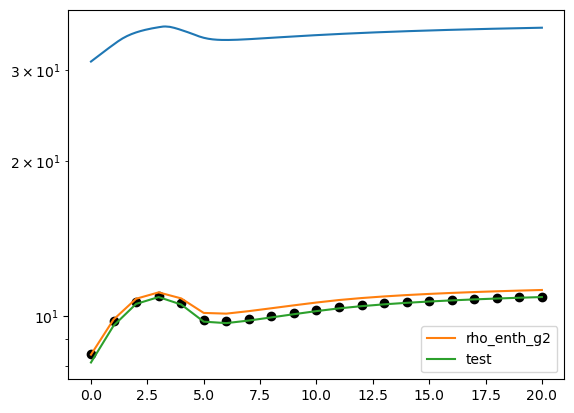

In [218]:
if not in_script:

    plt.plot(data_history['times'], data_history['etot_observer'])

    total = []
    rho_enth_g2 = []
    pressures = []
    b2 = []
    bcrossbeta = []
    test = []
    for i in range(21):
        with open(f'/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/corrT1_dens/prod1_corr_ampl/results_incl30/results_corr0ampl1/joined_vtk/IntSh2-p1.0{i:02d}0.vtk.pkl', 'rb') as f:
            data = pkl.load(f)[0]
    #     beta_vec = data['combined_beta_vec']
    #     beta_sqr = data['combined_beta']**2
    #     gamma = data['combined_gamma']

        beta_vec = np.moveaxis([data['vel1'], data['vel2'], data['vel3']], 0,-1)
        beta_sqr = np.sqrt(data['vel1']**2 + data['vel2']**2 + data['vel3']**2)
        gamma = 1 / sqrt(1 - beta_sqr)

        rho = data['rho']
        press = data['press']
    #     enthalpy = data['enthalpy']
        enthalpy = 1.0 +( adiab_idx / (adiab_idx - 1)) * press / rho
        Bfluid_vec = np.moveaxis([data['Bcc_fluid_1'], data['Bcc_fluid_2'], data['Bcc_fluid_3']], 0,-1)
        Bfluid_sqr = data['Bcc_fluid_tot']**2

        Bcc_vec = np.moveaxis([data['Bcc1'], data['Bcc2'], data['Bcc3']], 0,-1)
        Bcc_sqr = npsum(Bcc_vec**2, axis=-1)

    #     etot = tf_deconvert(npmean(
    #         etot_observer (beta_vec, beta_sqr, gamma, rho, enthalpy, press, Bfluid_vec, Bfluid_sqr)
    #     ))
        etot = tf_deconvert(npmean(
            rho * enthalpy * gamma**2 - press + 0.5 * (1.0+beta_sqr) * Bfluid_sqr - 0.5 * npsum(beta_vec * Bfluid_vec, axis=-1)**2
        ))

        total.append(etot)
        rho_enth_g2.append(tf_deconvert(npmean(rho * enthalpy * gamma**2)))
        pressures.append(tf_deconvert(npmean(press)))
        b2.append(tf_deconvert(npmean(0.5 * (1.0+beta_sqr) * Bfluid_sqr)))
        bcrossbeta.append(tf_deconvert(npmean(0.5 * npsum(beta_vec * Bfluid_vec, axis=-1)**2)))

        # the Bfield in eq. (20) is Bcc (sim frame), NOT Bfluid...
        # - need to calculate Bobs, similar to Bfluid calculation
        # Bcc in the fluid frame
        data_vtk = data
        Bobs0 = BccFl0(
            gamma_jet,
            -beta_jet,0,0,
            data_vtk['Bcc1'],data_vtk['Bcc2'],data_vtk['Bcc3'],
        )
        Bobs1 = BccFli(
            gamma_jet, 
            -beta_jet, data_vtk['Bcc1'],
            Bobs0
        )
        Bobs2 = BccFli(
            gamma_jet, 
            0, data_vtk['Bcc2'],
            Bobs0
        )
        Bobs3 = BccFli(
            gamma_jet, 
            0, data_vtk['Bcc3'],
            Bobs0
        )
        Bobs_vec = np.moveaxis([Bobs1, Bobs2, Bobs3], 0,-1)
        Bobs_sqr = npsum(Bobs_vec**2, axis=-1)
        test.append(tf_deconvert(npmean(
            rho * enthalpy * gamma**2 - press + 0.5 * (1.0+beta_jet**2) * Bobs_sqr - 0.5 * npsum(beta_vec * Bobs_vec * 4*np.pi, axis=-1)**2
        )))

    total = np.array(total)
    plt.scatter(data_history['times'][::10], total, color='k')

    plt.plot(data_history['times'][::10], rho_enth_g2, label='rho_enth_g2')
    # plt.plot(data_history['times'][::10], pressures, label='pressures')
    # plt.plot(data_history['times'][::10], b2, label='b2')
    # plt.plot(data_history['times'][::10], bcrossbeta, label='bcrossbeta')

    plt.plot(data_history['times'][::10], test, label='test')

    plt.gca().set_yscale('log')
    plt.legend()

    plt.show(); plt.close()

In [133]:
# Stokes parameters
# - ref. Lyutikov et al. (2003, 2005)
# WARNING: Typesetting mistakes with vector products in Lyutikov et al. (2005)! Please compare with Lyutikov et al. (2003).

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def sin_local_incl (beta_vec, beta, n_vec):
    return sqrt(1-npsum((beta_vec/beta.repeat(3).reshape(beta_vec.shape)) * n_vec, axis=-1)**2)

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def stokes_kappa (nu):
    nu = tf_convert(nu)[0]
    return 0.25*sqrt(3) * gamma((3*p-1)/12) * gamma((3*p+7)/12) * (e**3 / (me*c**2)) * (3*e / (2*np.pi*me**3*c**5))**(0.5*(p-1)) * nu**(-0.5*(p-1))

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def stokes_I (sin_local_incl, doppler_factor, Bfluid, cos_xiprime):
    '''Stokes I parameter, before integrating over dS
     - see Lyutikov et al. (2005), eq. (2).
     - see Lyutikov et al. (2003), eq. (B7).
     - z=0 assumed,
     - as we only use ratios here, part of normalization identical between I, Q, and U is omitted.'''
    sin_local_incl, doppler_factor, Bfluid, cos_xiprime = tf_convert(sin_local_incl, doppler_factor, Bfluid, cos_xiprime)
    abs_sin_xiprime = sqrt(1.0 - cos_xiprime**2)
    return ((p+7/3)/(p+1)) * (1 / sin_local_incl) * doppler_factor**(2+0.5*(p-1)) * npabs(Bfluid*abs_sin_xiprime)**(0.5*(p+1))

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def stokes_Q (sin_local_incl, doppler_factor, Bfluid, cos_xiprime, cos_xitilde):
    '''Stokes Q parameter, before integrating over dS
     - see Lyutikov et al. (2005), eq. (2).
     - see Lyutikov et al. (2003), eq. (B7).
     - z=0 assumed,
     - as we only use ratios here, part of normalization identical between I, Q, and U is omitted.'''
    sin_local_incl, doppler_factor, Bfluid, cos_xiprime, cos_xitilde = tf_convert(sin_local_incl, doppler_factor, Bfluid, cos_xiprime, cos_xitilde)
    abs_sin_xiprime = sqrt(1.0 - cos_xiprime**2)
    return (1 / sin_local_incl) * doppler_factor**(2+0.5*(p-1)) * npabs(Bfluid*abs_sin_xiprime)**(0.5*(p+1)) * (2*cos_xitilde**2 - 1.0)

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def stokes_U (sin_local_incl, doppler_factor, Bfluid, cos_xiprime, sin_xitilde, cos_xitilde):
    '''Stokes U parameter, before integrating over dS
     - see Lyutikov et al. (2005), eq. (2).
     - see Lyutikov et al. (2003), eq. (B7).
     - z=0 assumed,
     - as we only use ratios here, part of normalization identical between I, Q, and U is omitted.'''
    sin_local_incl, doppler_factor, Bfluid, cos_xiprime, sin_xitilde, cos_xitilde = tf_convert(sin_local_incl, doppler_factor, Bfluid, cos_xiprime, sin_xitilde, cos_xitilde)
    abs_sin_xiprime = sqrt(1.0 - cos_xiprime**2)
    return (1 / sin_local_incl) * doppler_factor**(2+0.5*(p-1)) * npabs(Bfluid*abs_sin_xiprime)**(0.5*(p+1)) * 2.*sin_xitilde*cos_xitilde

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def stokes_qprime (Bfluid_vec, beta_vec, gamma, n_vec):
    '''Lyutikov et al. (2003), eq. (C3).'''
    return Bfluid_vec + np.cross(n_vec, np.cross(beta_vec, Bfluid_vec)) - ((gamma/(1+gamma)) * npsum(Bfluid_vec * beta_vec, axis=-1)).repeat(3).reshape(beta_vec.shape) * beta_vec

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def stokes_e (n_vec, qprime_vec):
    '''Lyutikov et al. (2003), eq. (C3).'''
    return np.cross(n_vec, qprime_vec) / sqrt(
        npsum(qprime_vec**2, axis=-1) - npsum(n_vec * qprime_vec, axis=-1)**2
    ).repeat(3).reshape(qprime_vec.shape)

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def stokes_cos_xitilde (e_vec, n_vec, l_vec):
    '''Lyutikov et al. (2003), eq. (C8).'''
    return npsum(e_vec * np.cross(n_vec, l_vec), axis=-1)

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def stokes_sin_xitilde (e_vec, l_vec):
    '''Lyutikov et al. (2003), eq. (C8).'''
    return npsum(e_vec * l_vec, axis=-1)

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def stokes_nprime (n_vec, gamma, beta_vec):
    '''Lyutikov et al. (2003), eq. (4).'''
    return (n_vec + (gamma * ((gamma/(gamma+1))*npsum(n_vec*beta_vec, axis=-1)-1)).repeat(3).reshape(beta_vec.shape) * beta_vec) / (gamma * (1 - npsum(n_vec*beta_vec, axis=-1))).repeat(3).reshape(beta_vec.shape)

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def stokes_cos_xiprime (Bfluid_vec, nprime_vec):
    '''Lyutikov et al. (2003), eq. (5).'''
    return npsum(Bfluid_vec * nprime_vec, axis=-1)

In [ ]:
# MAGNETIC FIELD CURVATURE

# TODO: could probably optimize it better, also: NOT tested for tensorflow yet

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def _vector_orientation (vectors):
    '''Returns orientation phi (Arc tan(y/x)) of the vector field.'''
    result = arctan(vectors[...,1] / vectors[...,0])
    result = where(
        vectors[...,0] > 0,
        result,
        result - np.pi
    )
    result = modulo(result, 2.*np.pi)
    return result

# we look at Bfield in counterclockwise manner, shifting by (dx,dy)
# note the margin to ensure periodicity
_phi_angles = tuple(np.arange(-0.75*np.pi, 2.75*np.pi, 0.25*np.pi))
_shifts = (
    (-1,-1), (0,-1), (1,-1),
    (1,0), (1,1), (0,1), (-1,1), (-1,0), (-1,-1), (0,-1), (1,-1),
    (1,0), (1,1), (0,1)
)
#@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def _bfield_angles (bfield, bfield_phi):
    '''For each cell, we limit ourselves to the three neighbours closest to the direction of Bfield in that cell. Then, we report the angles between center cell's Bfield and Bfield at these neighbours.'''
    # calculate which neighbouring cells are closest to where Bfield is pointing
    direction_distances = repeat(expand_dims(bfield_phi,-1),len(_phi_angles), axis=-1) - _phi_angles
    direction_idxs = top_k(
        np.reshape(np.abs(direction_distances), (-1,len(_phi_angles))),
        k=3
    )
    direction_idxs = reshape(direction_idxs, (*(direction_distances.shape[:-1]),3))
    npsort(direction_idxs, axis=-1)
    direction_distances = nptake_along_axis(
        direction_distances,
        direction_idxs,
        axis=-1
    )
    # calculate angles between Bfield vectors
    shift_vectors = nptake(
        np.array(_shifts),
        direction_idxs.flatten(),
        axis=0
    )
    shift_vectors = reshape(
        shift_vectors,
        (*(bfield_phi.shape),3,2)
    )
    shift_vectors = transpose(shift_vectors, (-2,-1,0,1))
    indices = np.meshgrid(range(bfield.shape[0]), range(bfield.shape[1]), indexing='ij')
    indices = np.stack(indices)
    indices = np.stack(3*[indices,])[...,1:-1,1:-1]
    rolled_indices = indices + shift_vectors
    bfield_rolled = np.array([
        bfield[i,j] for i,j in rolled_indices
    ])
    bfield_here = npstack(3*[bfield[...,1:-1,1:-1,:],])
    bfield_angles = arccos(
        npsum(
            bfield_here * bfield_rolled, axis=-1
        ) / sqrt(npsum(bfield_here**2, -1) * npsum(bfield_rolled**2, -1))
    )
    bfield_angles = transpose(swapaxes(bfield_angles, 0,-1), (1,0,2))
    
    # clean up and return
    del direction_idxs, shift_vectors, indices, rolled_indices, bfield_rolled, bfield_here
    return direction_distances, bfield_angles

@jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def _extract_bfield_curvature (direction_distance, bfield_angles, bfield_phi):
    x,y = direction_distance, bfield_angles
    a = ( 1./(x[...,2]-x[...,0]) ) * ( (y[...,2]-y[...,1])/(x[...,2]-x[...,1]) - (y[...,1]-y[...,0])/(x[...,1]-x[...,0]) )
    b = (y[...,1]-y[...,0])/(x[...,1]-x[...,0]) - a*(x[...,0]-x[...,1])
    c = y[...,0] - a*x[...,0]**2 - b*x[...,0]
    bfield_rotation = c
    #del x,y, a,b
    # we also need a length scale, we take it from the square-neighbourhood of our bfield
    vectors = npstack((
        cos(bfield_phi), sin(bfield_phi)
    ))
    # normalize so that one coordinate ==1 (i.e., we're on a unit square)
    vectors /= where(
        vectors[0] > vectors[1],
        vectors[0],
        vectors[1]
    )
    length = sqrt(npsum(
        vectors**2, axis=0
    ))
    #del vectors
    # calculate curvature radius
    curvature = bfield_rotation / length
    
    # clean up and return
    #del c, length 
    return transpose(curvature)

def bfield_curvature (data, verbose=False):
    # collect bfields as vectors
    bfield = swapaxes(np.array((
        data['Bcc1'],
        data['Bcc2'],
        #data['Bcc3'], # == 0
    )), 0,-1)
    if verbose: print('Calculating angles.. ', end='', flush=True)
    # at each cell, collect angles between the cell's Bfield direction, and Bfield directions in the neighbouring cells
    bfield_phi = _vector_orientation(bfield)[1:-1,1:-1]
    direction_distance, bfield_angles = _bfield_angles(bfield, bfield_phi)
    if verbose: print('done.', flush=True)
    if verbose: print('Interpolating and extracting curvature.. ', end='', flush=True)
    # now, interpolate these values as a function of position angle
    # we'll use simple piecewise parabolic interpolation (y = ax2+bx+c)
    curvature = _extract_bfield_curvature (direction_distance, bfield_angles, bfield_phi)
    del bfield, direction_distance, bfield_angles
    if verbose: print('done.', flush=True)
    
    # clean up and return
    del bfield_phi
    return curvature

In [ ]:
# UNITS

sim2phys = {
    'Time':simu_t, # sec
    'x1f':simu_len, # cm
    'x2f':simu_len, # cm
    'x3f':simu_len, # cm
    'x1v':simu_len, # cm
    'x2v':simu_len, # cm
    'x3v':simu_len, # cm
    'rho':simu_mass/simu_len**3, # g / cm^3
    'press':simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'vel1': 1.0, # c
    'vel2': 1.0, # c
    'vel3': 1.0, # c
    'vel_tot': 1.0, # c
    'Bcc1': simu_B, # sqrt(erg / cm^3)
    'Bcc2': simu_B, # sqrt(erg / cm^3)
    'Bcc3': simu_B, # sqrt(erg / cm^3)
    'Bcc_tot': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_0': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_1': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_2': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_3': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_tot': simu_B, # sqrt(erg / cm^3)
    'Bcc_fluid_tot_vsZ': simu_B, # sqrt(erg / cm^3)
    'enthalpy': simu_mass * (simu_len/simu_t)**2 / simu_mass, # erg/g
    'internal_energy': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'internal_energy_vsZ': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'ekin_observer': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'etot_observer': simu_mass * (simu_len/simu_t)**2 / simu_len**3, # erg / cm^3
    'j_nu': 1.0, # erg / cm**3
    'j_nu_vsZ': 1.0, # erg / cm**3
    'j_over_alpha_nu': 1.0, # erg / cm**2
    'j_over_alpha_nu_vsZ': 1.0, # erg / cm**2
    'flux_density': 1.0, # erg/(cm**2*sec) / cm**2
    'flux_density_vsZ': 1.0, # erg/(cm**2*sec) / cm**2
    'syn_emission_rate_per_dS': 1.0, # erg/(cm**2*sec)
    'spectrum': (1.0, 1.0), # (Hz, erg / (s cm**2 Hz) / cm**2)
    'ddt_internal_energy': simu_mass * (simu_len/simu_t)**2 / simu_len**3 / simu_t, # erg / cm^3 / s
    'ddt_internal_energy_vsZ': simu_mass * (simu_len/simu_t)**2 / simu_len**3 / simu_t, # erg / cm^3 / s
}

In [ ]:
def do_vertical_avg (data_vtk, quantity):
    dy = (data_vtk['x2v'][1] - data_vtk['x2v'][0])
    yrange = dy * len(data_vtk['x2v'])
    data_vtk[quantity+'_vsZ'] = tf_deconvert(npsum(data_vtk[quantity]*dy, axis=0) / yrange)
    
default_augment_kwargs = {
    'nu_res':128, 'nu_min':0.1*nu_int_min, 'nu_max':10.*nu_int_max,
    'nu_int_min':nu_int_min, 'nu_int_max':nu_int_max,
    'R_selection':R_choice, 'nu_selection':nu_choice,
    'filling_factor':1.0
}

def augment_vtk_data (data_vtk, previous_data_vtk=None, 
                      nu_res=128, nu_min=1., nu_max=1.1*nu_int_max,
                      nu_int_min=nu_int_min, nu_int_max=nu_int_max,
                      R_selection=R_choice, nu_selection=nu_choice,
                      filling_factor=1.0):
    
    ''' calculate auxiliary data '''
    
    xrange = (data_vtk['x1v'][1] - data_vtk['x1v'][0]) * len(data_vtk['x1v'])
    yrange = (data_vtk['x2v'][1] - data_vtk['x2v'][0]) * len(data_vtk['x2v'])
    
    # SR quantities
    # NOTE: in Athena 4.2 vel1, vel2, vel3 are 3-velocities. Instead Athena++ uses 4-velocities in the code (so they would need to be translated).
    
    # fluid velocities in collision frame
    vel_tot_sqr = sqr_vec_l2(data_vtk['vel1'], data_vtk['vel2'], data_vtk['vel3'])
    data_vtk['vel_tot'] = tf_deconvert(sqrt(vel_tot_sqr))
    gam = vsqr2gamma(vel_tot_sqr)
    data_vtk['gamma'] = tf_deconvert(gam)
    del vel_tot_sqr
    
    # fluid velocities in observer frame (boosted by beta_jet)
    beta_vec = moveaxis(np.array([data_vtk['vel1'], data_vtk['vel2'], data_vtk['vel3']]), 0,-1)
    n_vec = np.array([cos(incl), 0, -sin(incl)])
    combined_beta_vec, combined_beta, combined_gamma, doppler_factor = combined_doppler_factor(beta_vec, n_vec)
    data_vtk['combined_beta_vec'] = tf_deconvert(combined_beta_vec)
    data_vtk['combined_beta'] = tf_deconvert(combined_beta)
    data_vtk['combined_gamma'] = tf_deconvert(combined_gamma)
    data_vtk['doppler_factor'] = tf_deconvert(doppler_factor)

    # total Bcc in collision frame
    data_vtk['Bcc_tot'] = tf_deconvert(norm_vec_l2(data_vtk['Bcc1'], data_vtk['Bcc2'], data_vtk['Bcc3']))

    # Bcc in the fluid frame
    Bfl0 = BccFl0(
        gam,
        data_vtk['vel1'],data_vtk['vel2'],data_vtk['vel3'],
        data_vtk['Bcc1'],data_vtk['Bcc2'],data_vtk['Bcc3'],
    )
    Bfl1 = BccFli(
        gam, 
        data_vtk['vel1'], data_vtk['Bcc1'],
        Bfl0
    )
    Bfl2 = BccFli(
        gam, 
        data_vtk['vel2'], data_vtk['Bcc2'],
        Bfl0
    )
    Bfl3 = BccFli(
        gam, 
        data_vtk['vel3'], data_vtk['Bcc3'],
        Bfl0
    )
    Bcc_fluid_tot_sqr = sqr_vec_l2(Bfl1, Bfl2, Bfl3)
    Bcc_fluid_tot = sqrt(Bcc_fluid_tot_sqr)
    Bcc_fluid_vec = moveaxis(np.array([Bfl1,Bfl2,Bfl3]),0,-1)
    data_vtk['Bcc_fluid_0'] = tf_deconvert(Bfl0)
    data_vtk['Bcc_fluid_1'] = tf_deconvert(Bfl1)
    data_vtk['Bcc_fluid_2'] = tf_deconvert(Bfl2)
    data_vtk['Bcc_fluid_3'] = tf_deconvert(Bfl3)
    data_vtk['Bcc_fluid_tot'] = tf_deconvert(Bcc_fluid_tot)
    do_vertical_avg(data_vtk, 'Bcc_fluid_tot')

    # plasma parameters
    data_vtk['plasma_beta'] = tf_deconvert(plasma_beta(data_vtk['press'], Bcc_fluid_tot_sqr))
    data_vtk['magnetization'] = tf_deconvert(magnetization(Bcc_fluid_tot_sqr, data_vtk['rho']))
    
    # internal energy in the fluid frame
    # see Beckwith & Stone (2011), https://github.com/PrincetonUniversity/athena/wiki/Special-Relativity
    enth = enthalpy(adiab_idx, data_vtk['press'], data_vtk['rho'])
    data_vtk['enthalpy'] = tf_deconvert(enth)
    data_vtk['internal_energy'] = tf_deconvert(
        internal_energy(data_vtk['rho'], enth, gam, data_vtk['press'], Bcc_fluid_tot_sqr)
    ) # warning!: includes rest mass
    do_vertical_avg(data_vtk, 'internal_energy')
    data_vtk['ekin_observer'] = tf_deconvert(
        ekin_observer(combined_gamma, data_vtk['rho'])
    )
    do_vertical_avg(data_vtk, 'ekin_observer')
    data_vtk['etot_observer'] = tf_deconvert(
        etot_observer(
            beta_vec=combined_beta_vec, 
            beta_sqr=(combined_beta**2), 
            gamma=combined_gamma, 
            rho=data_vtk['rho'], 
            enthalpy=enth, 
            press=data_vtk['press'], 
            Bfluid_vec=Bcc_fluid_vec, 
            Bfluid_sqr=Bcc_fluid_tot_sqr
        )
    )
    do_vertical_avg(data_vtk, 'etot_observer')
    
    del Bcc_fluid_tot_sqr, enth
    
    # synchrotron emission diagnostics
    jnu = j_nu(nu2nu_fl(nu_selection,doppler_factor), Bcc_fluid_tot)
    data_vtk['j_nu'] = tf_deconvert(jnu)
    do_vertical_avg(data_vtk, 'j_nu')
    alphanu = alpha_nu(nu2nu_fl(nu_selection,doppler_factor), Bcc_fluid_tot)
    data_vtk['alpha_nu'] = tf_deconvert(alphanu)
    do_vertical_avg(data_vtk, 'alpha_nu')
    janu = j_over_alpha_nu(nu2nu_fl(nu_selection,doppler_factor), Bcc_fluid_tot)
    data_vtk['j_over_alpha_nu'] = tf_deconvert(janu)
    do_vertical_avg(data_vtk, 'j_over_alpha_nu')
    flux_tot = flux_total_per_dS(
        B=Bcc_fluid_tot, gamma=combined_gamma, df=doppler_factor,
        R=R_selection, 
        nu_min=nu_int_min, nu_max=nu_int_max
    )
    data_vtk['flux_density'] = tf_deconvert(flux_tot)
    do_vertical_avg(data_vtk, 'flux_density')
    
#     data_vtk['synEm_per_dSdt'] = tf_deconvert(
#         synEm_per_dSdt (
#             B=Bcc_fluid_tot,
#             gamma=combined_gamma,
#             df=doppler_factor,
#             R=R_selection, 
#             nu_min=nu_int_min, nu_max=nu_int_max
#     ))
#     do_vertical_avg(data_vtk, 'synEm_per_dSdt')
    
    nu_min, nu_max = tf_convert(nu_min, nu_max)
    freqs = logspace(log10(nu_min), log10(nu_max), nu_res)
    
    dS = (data_vtk['x1v'][1] - data_vtk['x1v'][0]) * (data_vtk['x2v'][1] - data_vtk['x2v'][0])
    if not low_memory:
        nu_grid, B_grid = meshgrid(freqs, Bcc_fluid_tot, indexing='ij')
        nu_grid, gamma_grid = meshgrid(freqs, combined_gamma, indexing='ij')
        nu_grid, df_grid = meshgrid(freqs, doppler_factor, indexing='ij')
        data_vtk['spectrum'] = [
            tf_deconvert(freqs),
            tf_deconvert(nansum(
                flux_nu_per_dS(
                    nu=nu_grid, 
                    B=B_grid,
                    gamma=gamma_grid,
                    doppler_factor=df_grid,
                    R=R_selection, 
                    filling_factor=filling_factor
                )*dS, axis=-1) / (xrange*yrange)
            )
        ]
    else:
        data_vtk['spectrum'] = [[],[]]
        for nu in tf_deconvert(freqs):
            data_vtk['spectrum'][0].append(nu)
            data_vtk['spectrum'][1].append(tf_deconvert(
                nansum(
                    flux_nu_per_dS(
                        nu=nu, B=Bcc_fluid_tot,
                        gamma=combined_gamma,
                        doppler_factor=doppler_factor,
                        R=R_selection,
                        filling_factor=filling_factor
                    )
                ) * dS / (xrange*yrange)
            ))
        data_vtk['spectrum'] = [np.array(data_vtk['spectrum'][0]), np.array(data_vtk['spectrum'][1])]
    
    # time derivatives
    if type(previous_data_vtk) is dict:
        for quantity in ['internal_energy','internal_energy_vsZ']:
            data_vtk['ddt_'+quantity] = (data_vtk[quantity]-previous_data_vtk[quantity]) / (data_vtk['Time']-previous_data_vtk['Time'])
            
    # magnetic field curvature
    data_vtk['curvature'] = bfield_curvature(data_vtk)
    
    # Stokes parameters
    Bfluid_vec = moveaxis([Bfl1,Bfl2,Bfl3],0,-1)
    qprime_vec = stokes_qprime(
        Bfluid_vec=Bfluid_vec, 
        beta_vec=combined_beta_vec, 
        gamma=combined_gamma,
        n_vec=n_vec
    )
    e_vec = stokes_e (
        n_vec=n_vec, 
        qprime_vec=qprime_vec
    )
    l_vec = np.array([sin(incl),0,cos(incl)])
    cos_xitilde = stokes_cos_xitilde(
        e_vec=e_vec, 
        n_vec=n_vec, 
        l_vec=l_vec
    )
    sin_xitilde = stokes_sin_xitilde(
        e_vec=e_vec,
        l_vec=l_vec
    )
    sin_loc_incl = sin_local_incl(
        beta_vec=combined_beta_vec,
        beta=combined_beta,
        n_vec=n_vec
    )
    nprime_vec = stokes_nprime(
        n_vec=n_vec, 
        gamma=combined_gamma, 
        beta_vec=combined_beta_vec
    )
    cos_xiprime = stokes_cos_xiprime(
        Bfluid_vec=Bfluid_vec,
        nprime_vec=nprime_vec
    )
    data_vtk['stokes_I'] = tf_deconvert(stokes_I(
        sin_local_incl=sin_loc_incl, 
        doppler_factor=doppler_factor, 
        Bfluid=Bcc_fluid_tot, 
        cos_xiprime=cos_xiprime
    ))
    data_vtk['stokes_Q'] = tf_deconvert(stokes_Q(
        sin_local_incl=sin_loc_incl, 
        doppler_factor=doppler_factor, 
        Bfluid=Bcc_fluid_tot, 
        cos_xiprime=cos_xiprime, 
        cos_xitilde=cos_xitilde
    ))
    data_vtk['stokes_U'] = tf_deconvert(stokes_U(
        sin_local_incl=sin_loc_incl, 
        doppler_factor=doppler_factor, 
        Bfluid=Bcc_fluid_tot, 
        cos_xiprime=cos_xiprime, 
        sin_xitilde=sin_xitilde, 
        cos_xitilde=cos_xitilde
    ))
    del Bfluid_vec, qprime_vec, e_vec, l_vec, cos_xitilde, sin_xitilde, sin_loc_incl, nprime_vec, cos_xiprime, 
    
    return data_vtk

In [ ]:
def read_vtk_file (vtk_filename, previous_data_vtk=None, out_dt=out_dt_vtk, augment_kwargs=default_augment_kwargs, tarpath=None):
    '''read and augment the data'''
    # check if tarpath has been extracted
    if tarpath != None and os.path.isdir('.'.join(tarpath.split('.')[:-1])):
        print('[read_vtk_file(%s)] tarpath already extracted. Using the extracted version.' % tarpath)
        vtk_filename = '.'.join(tarpath.split('.')[:-1]) + '/' + '/'.join(vtk_filename.split('/')[1:])
        tarpath = None
    if os.path.isfile(vtk_filename + '.pkl') or (tarpath != None and (vtk_filename+'.pkl' in [x.path for x in tarfile.open(tarpath).getmembers()])):
        vtk_filename += '.pkl'
    if '.pkl' in vtk_filename:
        if tarpath == None:
            with open(vtk_filename, 'rb') as f:
                data_vtk, augment_kwargs_loaded = pkl.load(f)
        else:
            tar = tarfile.open(tarpath)
            data_vtk = tar.extractfile(vtk_filename)
            data_vtk, augment_kwargs_loaded = pkl.load(data_vtk)
            tar.close()
        # recalculate augmentation if needed
        if force_recalc or augment_kwargs_loaded != augment_kwargs:
            data_vtk = augment_vtk_data(data_vtk, previous_data_vtk=previous_data_vtk, **augment_kwargs)
            if convert_vtk:
                if tarpath == None:
                    with open(vtk_filename,'wb') as f:
                        pkl.dump((data_vtk, augment_kwargs), f)
                else:
                    print('[read_vtk_file(%s)]: cannot edit tar archives to save *.pkl files, please extract the archive first. Continuing without saving the *.pkl file.' % vtk_filename)
    else:
        if tarpath == None:
            data_vtk = augment_vtk_data(vtk(vtk_filename, out_dt=out_dt_vtk), previous_data_vtk=previous_data_vtk, **augment_kwargs)
        else:
            tar = tarfile.open(tarpath, 'r')
            data_vtk = tar.extractfile(vtk_filename).read()
            data_vtk = augment_vtk_data(vtk(filename=vtk_filename, out_dt=1.0, input_string=data_vtk))
            tar.close()
        if convert_vtk:
            if tarpath == None:
                with open(vtk_filename + '.pkl','wb') as f:
                    pkl.dump((data_vtk, augment_kwargs), f)
                try: # if successful, remove the original vtk file
                    with open(vtk_filename + '.pkl','rb') as f:
                        _ = pkl.load(f)
                    del _
                    os.remove(vtk_filename)
                except Exception as e:
                    print(' - could not save a pkl from %s\n%s' % (vtk_filename, e))
            else:
                print('[read_vtk_file(%s)]: cannot edit tar archives to save *.pkl files, please extract the archive first. Continuing without saving the *.pkl file.' % vtk_filename)
    return data_vtk

In [ ]:
history_quantities = ['times', 'internal_energy', 'flux_density', 'syn_emission_rate_per_dS', 'ekin_observer', 'etot_observer', 'polarization_degree', 'polarization_evpa', 'Q_integral', 'U_integral', 'I_integral']
# 'synEm_per_dSdt_mean', 

def _precalc_history_batch (vtk_filenames, out_dt=out_dt_vtk, augment_kwargs=default_augment_kwargs, tarpath=None):
    previous_data_vtk = None
    history = {}
    for quantity in history_quantities:
        history[quantity] = []
    for vtk_filename in vtk_filenames:
        fileno = int(vtk_filename.split('/')[-1].split('.')[1])
        # read and augment the data
        try:
            data_vtk = read_vtk_file(vtk_filename, previous_data_vtk, out_dt=out_dt, augment_kwargs=augment_kwargs, tarpath=tarpath)
        except Exception as e:
            print('[precalc_history] Could not read vtk file %s, error occured:' % vtk_filename)
            print(e)
            print(' - the file will be ignored.')
            continue
        # calculate history variables
        history['times'].append(fileno*out_dt)
        # energy components
        history['internal_energy'].append(tf_deconvert(
            npmean(data_vtk['internal_energy_vsZ'])
        ))
        history['ekin_observer'].append(tf_deconvert(
            npmean(data_vtk['ekin_observer_vsZ'])
        ))
        history['etot_observer'].append(tf_deconvert(
            npmean(data_vtk['etot_observer_vsZ'])
        ))
        history['flux_density'].append(tf_deconvert(
            npmean(data_vtk['flux_density_vsZ'])
        ))
        # synchrotron emission
        history['syn_emission_rate_per_dS'].append(get_cgs_value(tf_deconvert(
            syn_emission_rate_per_dS(data_vtk['flux_density'], doppler_factor=data_vtk['doppler_factor'])
        )))
#         history['synEm_per_dSdt_mean'].append(get_cgs_value(tf_deconvert(
#             npmean(data_vtk['synEm_per_dSdt'])
#         )))
        # polarization from the Stokes parameters
        Q_integral = tf_deconvert(nansum(data_vtk['stokes_Q']))
        U_integral = tf_deconvert(nansum(data_vtk['stokes_U']))
        I_integral = tf_deconvert(nansum(data_vtk['stokes_I']))
        history['Q_integral'].append(Q_integral)
        history['U_integral'].append(U_integral)
        history['I_integral'].append(I_integral)
        history['polarization_degree'].append(tf_deconvert(
            sqrt(Q_integral**2 + U_integral**2) / I_integral
        ))
        history['polarization_evpa'].append(tf_deconvert(
            0.5 * np.arccos(Q_integral / sqrt(Q_integral**2 + U_integral**2))
        ))
        del Q_integral, U_integral, I_integral
        # move on
        del previous_data_vtk
        previous_data_vtk = data_vtk
    for quantity in history_quantities:
        history[quantity] = np.array(history[quantity])
    history['ddt_internal_energy'] = (history['internal_energy'][1:] - history['internal_energy'][:-1]) / (history['times'][1:] - history['times'][:-1])
    history['ddt_internal_energy'] = np.insert(history['ddt_internal_energy'], 0, np.nan)
    return history

def precalc_history (vtk_filenames, out_dt=out_dt_vtk, augment_kwargs=default_augment_kwargs, tarpath=None):
    print('Calculating history..')
    if nproc_history == 1:
        history = _precalc_history_batch(vtk_filenames, out_dt=out_dt, augment_kwargs=augment_kwargs, tarpath=tarpath)
    else:
        from pathos.pools import ProcessPool # an alternative to Python's multiprocessing
        history = {}
        # prepare batches for parallel processing
        batches = np.array_split(vtk_filenames, nproc_history)
        for i in range(nproc_history-1):
            batches[i+1] = np.insert(batches[i+1], 0, batches[i][-1])
        # process batch histories
        with ProcessPool(nproc_history) as pool:
            batch_histories = pool.map(
                lambda x : _precalc_history_batch(
                    x, out_dt=out_dt, augment_kwargs=augment_kwargs, tarpath=tarpath
                ), 
                batches
            )
        # combine batch histories
        for batch_history in batch_histories:
            for quantity in batch_history.keys():
                if quantity not in history.keys():
                    history[quantity] = batch_history[quantity]
                else:
                    history[quantity] = np.append(history[quantity], batch_history[quantity][1:])
        del batch_histories
    print(' - history calculation done.')
    
    return history

--------------
# Single-dataset dashboard

In [ ]:

if processing_type == 'dashboard':
    
    # check if we are reading from a folder or from a tarfile
    if ('.tgz' in datapath) and os.path.isdir(datapath[:-4]):
        print('Tarfile %s has already been extracted, using the extracted version.' % datapath)
        datapath = datapath[:-4]+'/'
    using_tarfile = ('.tgz' in datapath)

    if not using_tarfile:
        vtk_filenames = sorted(list(set(
            glob.glob(datapath + 'joined_vtk/*.vtk') + [x[:-4] for x in glob.glob(datapath + 'joined_vtk/*.vtk.pkl')]
        )))
    else:
        tar = tarfile.open(datapath)
        vtk_filenames = sorted(
            [x.path for x in tar.getmembers() if (x.path[-4:] == '.vtk')] + [x.path[:-4] for x in tar.getmembers() if (x.path[-8:] == '.vtk.pkl')]
        )
        tar.close()

    outpath = './temp_dashboard/'
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    n_levels = 64
    minmax_kwargs = {
        'plasma_beta': [1.0e-4, 1.0e4]
    }

    # WARNING: add_snapshot_FIFO below is NOT embarassingly parallelizable, but does significantly save memory
    def dashboard_frame (i_vtk, verbose=False, save=True, recalculate=False, previous_data_vtk=None, history=None, augment_kwargs=default_augment_kwargs, tarpath=None):

        import numpy as np
        import matplotlib.pyplot as plt
        import matplotlib.gridspec as gridspec

        from read_vtk import vtk

        fileno = int(vtk_filenames[i_vtk].split('/')[-1].split('.')[1])
        vtk_time = fileno * out_dt_vtk # presumably we can trust this..

        print('Processing vtk no %i, vtk_time = %.2e..' % (i_vtk, vtk_time), flush=True)

        # see whether we can skip the file as already plotted
        outfile = (outpath + 'dashboard_%05i.png') % fileno
        if save and not recalculate and os.path.exists(outfile):
            print(' - file already plotted, skipping.', flush=True)
            return

        # initialize the plot
        fig = plt.figure(figsize=(24,12))
        gs = gridspec.GridSpec(4,8, width_ratios=[1,0.1,0.1,1,0.1,0.1,1,0.1])
        plt.suptitle('Time = %.2f sec.' % (vtk_time * sim2phys['Time'],))

        # ----------------------------------------------------------

        if verbose:
            print(' - processing vtk data..', flush=True)

        # load, process, and plot the vtk file (mhd quantities)

        if previous_data_vtk == None and i_vtk > 0:
            previous_data_vtk = read_vtk_file(vtk_filenames[i_vtk-1], previous_data_vtk=None, out_dt=out_dt_vtk, augment_kwargs=augment_kwargs, tarpath=tarpath)

        data_vtk = read_vtk_file(vtk_filenames[i_vtk], previous_data_vtk=previous_data_vtk, out_dt=out_dt_vtk, augment_kwargs=augment_kwargs, tarpath=tarpath)

        # plot

        plt.subplot(gs[0,0])
        plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['magnetization'], levels=n_levels)
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.title('Magnetization (fl. frame)')
        plt.ylabel('y [lt-sec]')
        plt.colorbar(cax=plt.subplot(gs[0,1]))

        plt.subplot(gs[1,0])
        plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['Bcc_fluid_tot'] * sim2phys['Bcc_fluid_tot'], levels=n_levels)
        plt.title('Bfield (fl. frame) [ ( erg $/$ cm$^3 $)$^{1/2}$ ]')
        plt.ylabel('y [lt-sec]')
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.colorbar(cax=plt.subplot(gs[1,1]))

        ax = plt.subplot(gs[2,0])
        plt.plot(data_vtk['x1v'], data_vtk['Bcc_fluid_tot_vsZ'] * sim2phys['Bcc_fluid_tot_vsZ'], 'k-')
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.ylabel('y [lt-sec]')
        plt.title('Bfield (fl. frame) [ ( erg $/$ cm$^3 $)$^{1/2}$ ]')
        ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))

        ax = plt.subplot(gs[3,0])
        plt.contourf(data_vtk['x1v'], data_vtk['x2v'], 
                     np.where(np.logical_and(data_vtk['plasma_beta'] > minmax_kwargs['plasma_beta'][0],
                                             data_vtk['plasma_beta'] < minmax_kwargs['plasma_beta'][1]), 
                              np.log10(data_vtk['plasma_beta']), np.nan),
                     levels=n_levels)
        plt.title('Log$_{10}$ Plasma $\\beta$')
        plt.ylabel('y [lt-sec]')
        plt.xlabel('x [lt-sec]')
        plt.colorbar(cax=plt.subplot(gs[3,1]))
        ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
        ax.set_ylim(min(data_vtk['x2v']), max(data_vtk['x2v']))

        plt.subplot(gs[0,3])
        plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['rho'] * sim2phys['rho'], levels=n_levels)
        plt.title('Density (fl. frame) [ g $/$ cm$^3$ ]')
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.ylabel('y [lt-sec]')
        plt.colorbar(cax=plt.subplot(gs[0,4]))

        plt.subplot(gs[1,3])
        plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['flux_density'] * sim2phys['flux_density'], levels=n_levels)
        plt.title('Syn. flux / dS [ erg $/$ (cm$^2$ s) $/$ cm$^2$ ]')
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.ylabel('y [lt-sec]')
        plt.colorbar(cax=plt.subplot(gs[1,4]))

        ax = plt.subplot(gs[2,3])
        plt.plot(data_vtk['x1v'], data_vtk['j_nu_vsZ'] * sim2phys['j_nu_vsZ'], 'k-')
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.ylabel('$j_{\\nu}(1.4$ PHz$)$ [ erg $/$ cm$^3$ ]')
        ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
        ax2 = plt.twinx()
        plt.plot(data_vtk['x1v'], data_vtk['j_over_alpha_nu_vsZ'] * sim2phys['j_over_alpha_nu_vsZ'], 'b-')
        plt.ylabel('$j_{\\nu}/\\alpha_{\\nu}(1.4$ PHz$)$ [ erg $/$ cm$^2$ ]')
        ax2.spines['right'].set_color('b')
        ax2.tick_params(axis='y', which='both', colors='b')
        ax2.yaxis.label.set_color('b')

        plt.subplot(gs[0,6])
        plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['internal_energy'] * sim2phys['internal_energy'], levels=n_levels)
        plt.title('Internal energy, $U$ (fl. frame) [ erg $/$ cm$^3$ ]')
        plt.gca().axes.xaxis.set_ticklabels([])
        plt.ylabel('y [lt-sec]')
        plt.colorbar(cax=plt.subplot(gs[0,7]))

        if 'ddt_internal_energy' in data_vtk.keys():
            plt.subplot(gs[1,6])
            plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['ddt_internal_energy'] * sim2phys['ddt_internal_energy'], levels=n_levels)
            plt.title('d(Internal energy)/dt, $\\dot{U}$ (fl. frame) [ erg $/$ (cm$^3$ s) ]')
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.ylabel('y [lt-sec]')
            plt.colorbar(cax=plt.subplot(gs[1,7]))

            ax = plt.subplot(gs[2,6])
            plt.plot(data_vtk['x1v'], data_vtk['internal_energy_vsZ'] * sim2phys['internal_energy_vsZ'], 'k-')
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.ylabel('$U$ [ erg $/$ cm$^3$ ]')
            ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
            ax2 = plt.twinx()
            plt.plot(data_vtk['x1v'], data_vtk['ddt_internal_energy_vsZ'] * sim2phys['ddt_internal_energy_vsZ'], 'b-')
            plt.ylabel('$\\dot{U}_{\\rm avg}$ [ erg $/$ (cm$^3$ s) ]')
            ax2.spines['right'].set_color('b')
            ax2.tick_params(axis='y', which='both', colors='b')
            ax2.yaxis.label.set_color('b')

        ax = plt.subplot(gs[3,6])
        plt.plot(
            data_vtk['spectrum'][0] * sim2phys['spectrum'][0], 
            data_vtk['spectrum'][1] * sim2phys['spectrum'][1], 'k-')
        ax.set_xscale('log')
        ax.set_yscale('log')
        plt.xlabel('$\\nu$ [Hz]')
        plt.ylabel('$F_{\\nu\\rm,syn}$ [ erg $/$ (s cm$^2$ Hz) $/$ cm$^2$ ]')
        plt.axvline(augment_kwargs['nu_int_min'], color='k', ls=':')
        plt.axvline(augment_kwargs['nu_int_max'], color='k', ls=':')

        # set the plot range to vtk data
        for j in range(2):
            for i in range(3):
                ax = plt.subplot(gs[j,3*i])
                ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
                ax.set_ylim(min(data_vtk['x2v']), max(data_vtk['x2v']))

        # plot the history data
        if type(history) == dict:
            ax = plt.subplot(gs[3,3])
            mask = history['times'] < vtk_time
            plt.plot(
                history['times'][mask] * sim2phys['Time'], 
                history['ddt_internal_energy'][mask] * sim2phys['ddt_internal_energy'], 'r-')
            mask = history['times'] == vtk_time
            plt.scatter(
                history['times'][mask] * sim2phys['Time'], 
                history['ddt_internal_energy'][mask] * sim2phys['ddt_internal_energy'], color='r', s=8)
            mask = history['times'] > vtk_time
            plt.plot(
                history['times'][mask] * sim2phys['Time'], 
                history['ddt_internal_energy'][mask] * sim2phys['ddt_internal_energy'], 'r:')
            plt.ylabel('$\dot{U}_{\\rm avg}$ [erg $/$ (cm$^3$ s)]')
            plt.xlabel('Time [sec]')
            ax.spines['left'].set_color('r')
            ax.tick_params(axis='y', which='both', colors='r')
            ax.yaxis.label.set_color('r')
            ax2 = plt.twinx()
            mask = history['times'] < vtk_time
            plt.plot(
                history['times'][mask] * sim2phys['Time'],
                history['flux_density'][mask] * sim2phys['flux_density'], 'b-')
            mask = history['times'] == vtk_time
            plt.scatter(
                history['times'][mask] * sim2phys['Time'],
                history['flux_density'][mask] * sim2phys['flux_density'], color='b', s=8)
            mask = history['times'] > vtk_time
            plt.plot(
                history['times'][mask] * sim2phys['Time'],
                history['flux_density'][mask] * sim2phys['flux_density'], 'b:')
            plt.ylabel('Avg. syn. flux / dS [${\\rm erg}/({\\rm cm}^2{\\rm s}) / {\\rm cm}^2$]')
            ax2.spines['right'].set_color('b')
            ax2.tick_params(axis='y', which='both', colors='b')
            ax2.yaxis.label.set_color('b')

        # clean up
        del data_vtk

        if verbose:
            print('     done.', flush=True)

        #plt.tight_layout()
        if save:
            plt.savefig(outfile, format='png', dpi=300, facecolor='w')
        else:
            plt.show()
        plt.close()

        print(' - frame done.', flush=True)

In [ ]:
if processing_type == 'dashboard':
    if '.tgz' not in datapath:
        history_outfile = datapath+'history.pkl'
        if force_recalc or not os.path.exists(history_outfile):
            history = precalc_history(vtk_filenames, out_dt=out_dt_vtk)
            with open(history_outfile, 'wb') as f:
                pkl.dump(history, f)
            force_recalc = False # recalc done
        else:
            with open(history_outfile, 'rb') as f:
                history = pkl.load(f)
    else:
        tar = tarfile.open(datapath)
        extract = False
        history_outfile = ''.join([x.path if ('history.pkl' in x.path) else '' for x in tar.getmembers()])
        if history_outfile == '': # create the history file
            
            # is we need to save *.pkl files and we are using tarfile, it needs to be extracted to be edited
            print('Extracting tarfile %s to add history.pkl.. ' % datapath, end='')
            extract = True
            tar.extractall(path = '/'.join(datapath.split('/')[:-1]))
            datapath = datapath[:-4]+'/'
            vtk_filenames = [datapath+'/'.join(x.split('/')[1:]) for x in vtk_filenames]
            print('done.')
        
            # calculate the history
            history = precalc_history(vtk_filenames, out_dt=out_dt_vtk)
            # save the history
            history_outfile = datapath+'history.pkl'
            with open(history_outfile, 'wb') as f:
                pkl.dump(history, f)
            force_recalc = False # recalc done
        else:
            history = pkl.load(tar.extractfile(history_outfile))
        tar.close()
        
        # remove the tarfile if extracted
        if extract:
            os.remove(datapath[:-1]+'.tgz')
            datapath = datapath

In [ ]:
if processing_type == 'dashboard':
    # is we need to save *.pkl files and we are using tarfile, it needs to be extracted to be edited
    extract = False
    tarpath = None
    if '.tgz' in datapath:
        if os.path.isdir('.'.join(datapath.split('.')[:-1])): # already extracted
            datapath = '.'.join(datapath.split('.')[:-1])
            tarpath = None
        elif convert_vtk: # check if we need to extract to convert vtk to pkl
            contents = [(1 if x.path[:-4] == '.vtk' else 0) for x in tarfile.open(datapath).getmembers()]
            extract = (np.sum(contents) > 0)
            if extract:
                print('Extracting tarfile %s.. ' % datapath, end='')
                tar = tarfile.open(datapath)
                tar.extractall(path = '.'.join(datapath.split['.'][:-1]))
                datapath = datapath[:-4]+'/'
                vtk_filenames = [datapath+'/'.join(x.split('/')[1:]) for x in vtk_filenames]
                tar.close()
                tarpath = None
                print('done.')
            else:
                tarpath = datapath
        else: # keep reading from the compressed tarfile
            tarpath = datapath
    # now, parallelize the frame generation
    from pathos.pools import ProcessPool # an alternative to Python's multiprocessing
    chunks = np.array_split(range(len(vtk_filenames)), nproc)
    def worker (ichunk):
        indices = chunks[ichunk]
        data_vtk = None
        for i in indices:
            data_vtk = dashboard_frame(i_vtk=i, recalculate=force_recalc, previous_data_vtk=data_vtk, history=history, augment_kwargs=default_augment_kwargs, verbose=False, tarpath=tarpath)
    with ProcessPool(nproc) as pool:
        _ = pool.map(worker, list(range(nproc)))
    # tar when done and clean up
    if extract or (tar_when_done and '.tgz' not in datapath):
            print('Archiving into tarfile %s.. ' % datapath, end='')
            workdir = os.getcwd()
            tar_location = '/'.join(datapath.split('/')[:-2])
            if tar_location != '':
                os.chdir(tar_location)
            os.system('tar -cvzf %s %s' % (datapath.split('/')[-2] + '.tgz',datapath.split('/')[-2]))
            if os.path.isfile(datapath[:-1] + '.tgz'):
                rmtree(datapath)
                datapath = datapath[:-1] + '.tgz'
                tarpath = datapath
            os.chdir(workdir)
            print('done.')

In [ ]:
if processing_type == 'dashboard':
    # render the movie
    try:
        print("Rendering the movie..", flush=True)
        command = ("ffmpeg -threads %i -y -r 20 -f image2 -i \"%sdashboard_%%*.png\" -f mp4 -q:v 0 -vcodec mpeg4 -r 20 dashboard.mp4" % (nproc, outpath,))
        print(command, flush=True)
        os.system(command)
        if os.path.isfile('dashboard.mp4'):
            os.system('rm -r ' + outpath)
        else:
            raise
    except Exception as e:
        print('Error while rendering movie:\n%s\n -- please try to manually convert the .png files generated in %s.' % (e, outpath), flush=True)

In [ ]:
if False and processing_type == 'dashboard' and not in_script:
    dashboard_frame(80, save=False, recalculate=False, history=history, tarpath=tarpath)

In [ ]:
if processing_type == 'dashboard':
    print("DASHBOARD PROCESSING DONE.", flush=True)
    sys.exit()

-----------
# Two-dataset comparison

In [ ]:
if processing_type == 'comparison':
    
    def diff_name(a,b):
        """Returns a comparison-style name based on two strings"""
        # don't edit the original paths
        a,b = copy(a), copy(b)
        # strip the .tgz, if needed
        if a[-4:] == '.tgz': a = a[:-4]
        if b[-4:] == '.tgz': b = b[:-4]
        # strip the trailing /
        if a[-1] == '/': a = a[:-1]
        if b[-1] == '/': b = b[:-1]
        # first, read from the front
        idxl = 0
        while a[:idxl] == b[:idxl]:
            idxl += 1
        # then, read from the back
        idxr = 1
        while a[-idxr:] == b[-idxr:]:
            idxr += 1
        na, nb = len(a), len(b)
        return a[:(idxl-1)] + '-' + a[(idxl-1):(na-idxr+1)] + '-vs-' + b[(idxl-1):(nb-idxr+1)] + '-' + b[(nb-idxr+1):]

    # create lists of vtk files to be compared
    linestyles_comp = ['k-', 'b-']

    vtk_filenames_comp = []
    history_outfile_comp = []
    history_comp = []
    for idx in range(2):
        if datapaths_comp[idx][-4:] == '.tgz':
            vtk_filenames_comp.append(sorted(
                [x.path for x in tarfile.open(datapaths_comp[idx]).getmembers() if x.path[-4:] == '.vtk'] + [x.path[:-4] for x in tarfile.open(datapaths_comp[idx]).getmembers() if x.path[-8:] == '.vtk.pkl']
            ))
            history_outfile_comp.append(
                ''.join([(x.path if 'history.pkl' in x.path else '') for x in tarfile.open(datapaths_comp[idx]).getmembers()])
            )
        else:
            vtk_filenames_comp.append(
                sorted(list(set(
                    glob.glob(datapaths_comp[idx] + 'joined_vtk/*.vtk') + [x[:-4] for x in glob.glob(datapaths_comp[idx] + 'joined_vtk/*.vtk.pkl')]
                )))
            )
            history_outfile_comp.append(datapaths_comp[idx] + 'history.pkl')

        # precalculate histories if needed
        # uncompressed datapath
        if datapaths_comp[idx][-4:] != '.tgz':
            if force_recalc or not os.path.exists(history_outfile_comp[idx]):
                history_comp.append(precalc_history(vtk_filenames_comp[idx], out_dt=out_dt_vtk))
                with open(history_outfile_comp[idx], 'wb') as f:
                    pkl.dump(history_comp[idx], f)
            else:
                with open(history_outfile_comp[idx], 'rb') as f:
                    history_comp.append(pkl.load(f))
        # tar'red datapath
        else:
            extract = False
            tar = tarfile.open(datapaths_comp[idx])
            if force_recalc or history_outfile_comp[idx] not in [x.path for x in tar.getmembers()]:
                # is we need to save *.pkl files and we are using tarfile, it needs to be extracted to be edited
                print('Extracting tarfile %s to add history.pkl.. ' % datapaths_comp[idx], end='')
                extract = True
                tar.extractall(path = '/'.join(datapaths_comp[idx].split('/')[:-1]))
                datapaths_comp[idx] = datapaths_comp[idx][:-4]+'/'
                vtk_filenames_comp[idx] = [datapaths_comp[idx]+'/'.join(x.split('/')[1:]) for x in vtk_filenames_comp[idx]]
                print('done.')

                # calculate the history
                history_comp.append(precalc_history(vtk_filenames_comp[idx], out_dt=out_dt_vtk))
                # save the history
                history_outfile = datapaths_comp[idx]+'history.pkl'
                with open(history_outfile, 'wb') as f:
                    pkl.dump(history_comp[idx], f)
            else:
                history_comp.append(pkl.load(tar.extractfile(history_outfile_comp[idx])))
            tar.close()

            # remove the tarfile if extracted
            if extract:
                os.remove(datapaths_comp[idx][:-1]+'.tgz')
            
                
    force_recalc = False # recalc done

    comp_name = diff_name(datapaths_comp[0], datapaths_comp[1])
    outpath = comp_name + '_temp_comparison/'
    outfile = comp_name + '_comparison.mp4'
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    n_levels = 64
    
    def get_fileno (filename):
        return int(filename.split('/')[-1].split('.')[1])

    # WARNING: add_snapshot_FIFO below is NOT embarassingly parallelizable, but does significantly save memory
    def comparison_frame (i_vtk, verbose=False, save=True, recalculate=False, history_comp=None, augment_kwargs=default_augment_kwargs, tarpaths=[None,None]):

        import numpy as np
        import matplotlib.pyplot as plt
        import matplotlib.gridspec as gridspec

        from read_vtk import vtk

        fileno = get_fileno(vtk_filenames_comp[0][i_vtk])
        if fileno != get_fileno(vtk_filenames_comp[1][i_vtk]):
            print('[comparison_frame] file lists not aligned. Aborting.')
            return

        vtk_time = fileno * out_dt_vtk # presumably we can trust this..

        print('Processing vtk no %i, vtk_time = %.2e..' % (i_vtk, vtk_time), flush=True)

        # see whether we can skip the file as already plotted
        outfile = (outpath + 'comparison_%05i.png') % fileno
        if save and not recalculate and os.path.exists(outfile):
            print(' - file already plotted, skipping.', flush=True)
            return

        # initialize the plot
        fig = plt.figure(figsize=(24,12))
        gs = gridspec.GridSpec(4,8, width_ratios=[1,0.1,0.1,1,0.1,0.1,1,0.1])
        plt.suptitle('Time = %.2f sec.' % (vtk_time * sim2phys['Time'],))

        # ----------------------------------------------------------

        if verbose:
            print(' - processing vtk data..', flush=True)

        data_vtk = []
        for idx in range(2):
            # load, process, and plot the vtk file (mhd quantities)
            try:
                data_vtk = read_vtk_file(vtk_filenames_comp[idx][i_vtk], previous_data_vtk=None, out_dt=out_dt_vtk, augment_kwargs=augment_kwargs, tarpath=tarpaths[idx])
            except Exception as e:
                print('Could not reat vtk file ', vtk_filenames_comp[idx][i_vtk], 'continuiung..')
                continue

            # plot

            plt.subplot(gs[idx,0])
            plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['magnetization'], levels=n_levels)
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.title('Magnetization (fl. frame)')
            plt.ylabel('y [lt-sec]')
            plt.colorbar(cax=plt.subplot(gs[idx,1]))

            plt.subplot(gs[idx,3])
            plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['flux_density'] * sim2phys['flux_density'], levels=n_levels)
            plt.title('Syn. flux / dS [ erg $/$ (cm$^2$ s) $/$ cm$^2$ ]')
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.ylabel('y [lt-sec]')
            plt.colorbar(cax=plt.subplot(gs[idx,4]))

            plt.subplot(gs[idx,6])
            plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['rho'] * sim2phys['rho'], levels=n_levels)
            plt.title('Density (fl. frame) [ g $/$ cm$^3$ ]')
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.ylabel('y [lt-sec]')
            plt.colorbar(cax=plt.subplot(gs[idx,7]))

            # --------------------------------------

            ax = plt.subplot(gs[2,0])
            plt.plot(data_vtk['x1v'], data_vtk['Bcc_fluid_tot_vsZ'] * sim2phys['Bcc_fluid_tot_vsZ'], linestyles_comp[idx])
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.title('Bfield (fl. frame) [ ( erg $/$ cm$^3 $)$^{1/2}$ ]')
            ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))

            ax = plt.subplot(gs[2,3])
            plt.plot(data_vtk['x1v'], data_vtk['j_nu_vsZ'] * sim2phys['j_nu_vsZ'], linestyles_comp[idx])
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.title('$j_{\\nu}(1.4$ PHz$)$ [ erg $/$ cm$^3$ ]')
            ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))

            ax = plt.subplot(gs[2,6])
            plt.plot(data_vtk['x1v'], data_vtk['internal_energy_vsZ'] * sim2phys['internal_energy_vsZ'], linestyles_comp[idx])
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.title('$U$ [ erg $/$ cm$^3$ ]')
            ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))

            ax = plt.subplot(gs[3,6])
            plt.plot(
                data_vtk['spectrum'][0] * sim2phys['spectrum'][0], 
                data_vtk['spectrum'][1] * sim2phys['spectrum'][1], linestyles_comp[idx])
            ax.set_xscale('log')
            ax.set_yscale('log')
            plt.xlabel('$\\nu$ [Hz]')
            plt.ylabel('$F_{\\nu\\rm,syn}$ [ erg $/$ (s cm$^2$ Hz) $/$ cm$^2$ ]')
            plt.axvline(augment_kwargs['nu_int_min'], color='k', ls=':')
            plt.axvline(augment_kwargs['nu_int_max'], color='k', ls=':')

            # set the plot range to vtk data
            for j in range(2):
                for i in range(3):
                    ax = plt.subplot(gs[j,3*i])
                    ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
                    ax.set_ylim(min(data_vtk['x2v']), max(data_vtk['x2v']))

            # plot the history data
            if type(history_comp[idx]) == dict:
                ax_Udot = plt.subplot(gs[3,0])
                ax_Fsyn = plt.subplot(gs[3,3])
                mask = history_comp[idx]['times'] < vtk_time
                ax_Udot.plot(
                    history_comp[idx]['times'][mask] * sim2phys['Time'], 
                    history_comp[idx]['ddt_internal_energy'][mask] * sim2phys['ddt_internal_energy'], 
                    linestyles_comp[idx])
                mask = history_comp[idx]['times'] == vtk_time
                ax_Udot.scatter(
                    history_comp[idx]['times'][mask] * sim2phys['Time'], 
                    history_comp[idx]['ddt_internal_energy'][mask] * sim2phys['ddt_internal_energy'],
                    color=linestyles_comp[idx][0], s=8)
                mask = history_comp[idx]['times'] > vtk_time
                ax_Udot.plot(
                    history_comp[idx]['times'][mask] * sim2phys['Time'], 
                    history_comp[idx]['ddt_internal_energy'][mask] * sim2phys['ddt_internal_energy'],
                    (linestyles_comp[idx][0] + ':'))
                ax_Udot.set_ylabel('$\dot{U}_{\\rm avg}$ [erg $/$ (cm$^3$ s)]')
                ax_Udot.set_xlabel('Time [sec]')

                mask = history_comp[idx]['times'] < vtk_time
                ax_Fsyn.plot(
                    history_comp[idx]['times'][mask] * sim2phys['Time'],
                    history_comp[idx]['flux_density'][mask] * sim2phys['flux_density'],
                    linestyles_comp[idx])
                mask = history_comp[idx]['times'] == vtk_time
                ax_Fsyn.scatter(
                    history_comp[idx]['times'][mask] * sim2phys['Time'],
                    history_comp[idx]['flux_density'][mask] * sim2phys['flux_density'],
                    color=linestyles_comp[idx][0], s=8)
                mask = history_comp[idx]['times'] > vtk_time
                ax_Fsyn.plot(
                    history_comp[idx]['times'][mask] * sim2phys['Time'],
                    history_comp[idx]['flux_density'][mask] * sim2phys['flux_density'],
                    (linestyles_comp[idx][0]+':'))
                plt.ylabel('Avg. syn. flux / dS [${\\rm erg}/({\\rm cm}^2{\\rm s}) / {\\rm cm}^2$]')

                # set up limits
                if npmax(history_comp[0]['times'] * sim2phys['Time']) > 4.0 and npmax(history_comp[1]['times'] * sim2phys['Time']) > 4.0:
                    mask = [
                        (history_comp[0]['times'] * sim2phys['Time'] > 4.0),
                        (history_comp[1]['times'] * sim2phys['Time'] > 4.0)
                    ]
                else:
                    mask = [
                        (history_comp[0]['times'] * sim2phys['Time'] > 0.0),
                        (history_comp[1]['times'] * sim2phys['Time'] > 0.0)
                    ]
                ax_Fsyn.set_ylim(
                    None,
                    npmax([
                        npmax(history_comp[0]['flux_density'][mask[0]]) * sim2phys['flux_density'],
                        npmax(history_comp[1]['flux_density'][mask[1]]) * sim2phys['flux_density']
                    ])
                )

            # clean up
            del data_vtk

        if verbose:
            print('     done.', flush=True)

        #plt.tight_layout()
        if save:
            plt.savefig(outfile, format='png', dpi=300, facecolor='w')
        else:
            plt.show()
        plt.close()

        print(' - frame done.', flush=True)

In [ ]:
if processing_type == 'comparison':
    # is we need to save *.pkl files and we are using tarfile, it needs to be extracted to be edited
    tarpaths = [None, None]
    extract = [False, False]
    for idx in range(2):
        if '.tgz' in datapaths_comp[idx]:
            if os.path.isdir('.'.join(datapaths_comp[idx].split('.')[:-1])):
                # tar already extracted
                datapaths_comp[idx] = os.path.isdir('.'.join(datapaths_comp[idx].split('.')[:-1]))
                tarpaths[idx] = None
            elif convert_vtk:
                # do we need to extract to convert vtk to pkl?
                contents = [(1 if x.path[:-4] == '.vtk' else 0) for x in tarfile.open(datapaths_comp[idx]).getmembers()]
                extract[idx] = (np.sum(contents) > 0)
                if extract[idx]:
                    print('Extracting tarfile %s.. ' % datapaths_comp[idx], end='')
                    tar = tarfile.open(datapaths_comp[idx])
                    tar.extractall(path = '.'.join(datapaths_comp[idx].split['.'][:-1]))
                    datapaths_comp[idx] = datapaths_comp[idx][:-4]+'/'
                    vtk_filenames_comp[idx] = [datapaths_comp[idx]+'/'.join(x.split('/')[1:]) for x in vtk_filenames_comp[idx]]
                    tar.close()
                    tarpaths[idx] = None
                    print('done.')
                else:
                    # otherwise keep the tar and read files directly from there
                    tarpaths[idx] = datapaths_comp[idx]
            else:
                tarpaths[idx] = datapaths_comp[idx]
    
    # fill in the gaps in datasets
    for idx in [0,1]:
        vtk_filenames_comp[idx] = sum([[elem1,]*(get_fileno(elem2)-get_fileno(elem1)) for elem1,elem2 in zip(vtk_filenames_comp[idx][:-1], vtk_filenames_comp[idx][1:])], []) + [vtk_filenames_comp[idx][-1],]
    lendiff = len(vtk_filenames_comp[1]) - len(vtk_filenames_comp[0])
    if lendiff > 0:
        vtk_filenames_comp[0] += [vtk_filenames_comp[0][-1],]*lendiff
    elif lendiff < 0:
        vtk_filenames_comp[1] += [vtk_filenames_comp[1][-1],]*(-lendiff)
    print('Dataset alignment:')
    for i in range(len(vtk_filenames_comp[0])):
        print('%i -- %i' % (get_fileno(vtk_filenames_comp[0][i]),get_fileno(vtk_filenames_comp[1][i])))
    print(' --- ')
    
    # now, parallelize the frame generation
    from pathos.pools import ProcessPool # an alternative to Python's multiprocessing
    chunks = np.array_split(range(len(vtk_filenames_comp[0])), nproc)
    def worker (ichunk):
        indices = chunks[ichunk]
        data_vtk = None
        for i in indices:
            data_vtk = comparison_frame(i_vtk=i, recalculate=force_recalc, history_comp=history_comp, augment_kwargs=default_augment_kwargs, verbose=False, tarpaths=tarpaths)
    with ProcessPool(nproc) as pool:
        _ = pool.map(worker, list(range(nproc)))
    # tar when done and clean up
    for idx in range(2):
        if extract[idx] or (tar_when_done and '.tgz' not in datapaths_comp[idx]):
            print('Archiving into tarfile %s.. ' % datapaths_comp[idx], end='')
            workdir = os.getcwd()
            tar_location = '/'.join(datapaths_comp[idx].split('/')[:-2])
            if tar_location != '':
                os.chdir(tar_location)
            try:
                os.system('cp %s %s' % (datapaths_comp[idx].split('/')[-2]+'/history.pkl', 'history_%s.pkl' % (datapaths_comp[idx].split('/')[-2].split('_')[-1],)))
            except Exception as e:
                pass
            os.system('tar -cvzf %s %s' % (datapaths_comp[idx].split('/')[-2] + '.tgz',datapaths_comp[idx].split('/')[-2]))
            if os.path.isfile(datapaths_comp[idx][:-1] + '.tgz'):
                rmtree(datapaths_comp[idx])
                datapaths_comp[idx] = datapaths_comp[idx][:-1] + '.tgz'
                tarpaths[idx] = datapaths_comp[idx]
            os.chdir(workdir)
            print('done.')

In [ ]:
if processing_type == 'comparison' and in_script:
    # render the movie
    try:
        print("Rendering the movie..", flush=True)
        command = ("ffmpeg -threads %i -y -r 20 -f image2 -i \"%scomparison_%%*.png\" -f mp4 -q:v 0 -vcodec mpeg4 -r 20 %s" % (nproc, outpath, outfile))
        print(command, flush=True)
        os.system(command)
        if os.path.isfile(outfile):
            os.system('rm -r ' + outpath)
        else:
            raise
    except Exception as e:
        print('Error while rendering movie:\n%s\n -- please try to manually convert the .png files generated in %s.' % (e, outpath), flush=True)
    print("COMPARISON PROCESSING DONE.", flush=True)

In [ ]:
if processing_type == 'comparison' and not in_script:
    comparison_frame(80, history_comp=history_comp, save=False)

---
# Experiment regarding long-term Fsyn enhancement
 (see Pjanka et al. 2022)

In [ ]:
if processing_type == 'expLongFsyn':
    
    def calc_alternative_augmentations (
        default_dict, new_bcc_dict, 
        nu_res=128, nu_min=1., nu_max=1.1*nu_int_max,
        nu_int_min=nu_int_min, nu_int_max=nu_int_max,
        R_selection=R_choice, nu_selection=nu_choice,
        filling_factor=1.0,
        calc_spectrum=False, 
        calc_curvature=False, 
        calc_stokes=False
    ):
        '''Uses the default-augmented file and appends Bfield and Fsyn data for alternative scenarios:
         - with Bfield from a separate non-corrugated (1D) run
         - with Bfield from the corrugated (2D) run but vertically-averaged into a 1D structure
         - with the above scaled so that the average is the same as the 1D run, leaving only the horizontal structure (but not the overall bfield enhancement)
         - with Bfield from the corrugated (2D) run scaled down so that the average matches the 1D case, leaving only the 2D structure (but not the overall bfield enhancement)'''
        
        data_vtk = default_dict
        
        for q in ('x1v', 'x2v'):
            new_bcc_dict[q] = data_vtk[q]
        xrange = (data_vtk['x1v'][1] - data_vtk['x1v'][0]) * len(data_vtk['x1v'])
        yrange = (data_vtk['x2v'][1] - data_vtk['x2v'][0]) * len(data_vtk['x2v'])

        # SR quantities
        gam = data_vtk['gamma']

        # fluid velocities in observer frame (boosted by beta_jet)
        beta_vec = moveaxis(np.array([data_vtk['vel1'], data_vtk['vel2'], data_vtk['vel3']]), 0,-1)
        n_vec = np.array([cos(incl), 0, -sin(incl)])
        combined_beta_vec = data_vtk['combined_beta_vec']
        combined_beta = data_vtk['combined_beta']
        combined_gamma = data_vtk['combined_gamma']
        doppler_factor = data_vtk['doppler_factor']

        # total Bcc in collision frame
        new_bcc_dict['Bcc_tot'] = tf_deconvert(norm_vec_l2(
            new_bcc_dict['Bcc1'], new_bcc_dict['Bcc2'], new_bcc_dict['Bcc3']
        ))

        # Bcc in the fluid frame
        Bfl0 = BccFl0(
            gam,
            data_vtk['vel1'],data_vtk['vel2'],data_vtk['vel3'],
            new_bcc_dict['Bcc1'],new_bcc_dict['Bcc2'],new_bcc_dict['Bcc3'],
        )
        Bfl1 = BccFli(
            gam, 
            data_vtk['vel1'], new_bcc_dict['Bcc1'],
            Bfl0
        )
        Bfl2 = BccFli(
            gam, 
            data_vtk['vel2'], new_bcc_dict['Bcc2'],
            Bfl0
        )
        Bfl3 = BccFli(
            gam, 
            data_vtk['vel3'], new_bcc_dict['Bcc3'],
            Bfl0
        )
        Bcc_fluid_tot_sqr = sqr_vec_l2(Bfl1, Bfl2, Bfl3)
        Bcc_fluid_tot = sqrt(Bcc_fluid_tot_sqr)
        Bcc_fluid_vec = moveaxis(np.array([Bfl1,Bfl2,Bfl3]),0,-1)
        new_bcc_dict['Bcc_fluid_0'] = tf_deconvert(Bfl0)
        new_bcc_dict['Bcc_fluid_1'] = tf_deconvert(Bfl1)
        new_bcc_dict['Bcc_fluid_2'] = tf_deconvert(Bfl2)
        new_bcc_dict['Bcc_fluid_3'] = tf_deconvert(Bfl3)
        new_bcc_dict['Bcc_fluid_tot'] = tf_deconvert(Bcc_fluid_tot)
        do_vertical_avg(new_bcc_dict, 'Bcc_fluid_tot')

        # plasma parameters
        new_bcc_dict['plasma_beta'] = tf_deconvert(plasma_beta(data_vtk['press'], Bcc_fluid_tot_sqr))
        new_bcc_dict['magnetization'] = tf_deconvert(magnetization(Bcc_fluid_tot_sqr, data_vtk['rho']))

        # internal energy in the fluid frame
        # see Beckwith & Stone (2011), https://github.com/PrincetonUniversity/athena/wiki/Special-Relativity
        enth = data_vtk['enthalpy']
        new_bcc_dict['internal_energy'] = tf_deconvert(
            internal_energy(data_vtk['rho'], enth, gam, data_vtk['press'], Bcc_fluid_tot_sqr)
        ) # warning!: includes rest mass
        do_vertical_avg(new_bcc_dict, 'internal_energy')
        new_bcc_dict['etot_observer'] = tf_deconvert(
            etot_observer(
                beta_vec=combined_beta_vec, 
                beta_sqr=(combined_beta**2), 
                gamma=combined_gamma, 
                rho=data_vtk['rho'], 
                enthalpy=enth, 
                press=data_vtk['press'], 
                Bfluid_vec=Bcc_fluid_vec, 
                Bfluid_sqr=Bcc_fluid_tot_sqr
            )
        )
        do_vertical_avg(new_bcc_dict, 'etot_observer')

        del Bcc_fluid_tot_sqr, enth

        # synchrotron emission diagnostics
        jnu = j_nu(nu2nu_fl(nu_selection,doppler_factor), Bcc_fluid_tot)
        new_bcc_dict['j_nu'] = tf_deconvert(jnu)
        do_vertical_avg(new_bcc_dict, 'j_nu')
        alphanu = alpha_nu(nu2nu_fl(nu_selection,doppler_factor), Bcc_fluid_tot)
        new_bcc_dict['alpha_nu'] = tf_deconvert(alphanu)
        do_vertical_avg(new_bcc_dict, 'alpha_nu')
        janu = j_over_alpha_nu(nu2nu_fl(nu_selection,doppler_factor), Bcc_fluid_tot)
        new_bcc_dict['j_over_alpha_nu'] = tf_deconvert(janu)
        do_vertical_avg(new_bcc_dict, 'j_over_alpha_nu')
        flux_tot = flux_total_per_dS(
            B=Bcc_fluid_tot, gamma=combined_gamma, df=doppler_factor,
            R=R_selection, 
            nu_min=nu_int_min, nu_max=nu_int_max
        )
        new_bcc_dict['flux_density'] = tf_deconvert(flux_tot)
        do_vertical_avg(new_bcc_dict, 'flux_density')

    #     data_vtk['synEm_per_dSdt'] = tf_deconvert(
    #         synEm_per_dSdt (
    #             B=Bcc_fluid_tot,
    #             gamma=combined_gamma,
    #             df=doppler_factor,
    #             R=R_selection, 
    #             nu_min=nu_int_min, nu_max=nu_int_max
    #     ))
    #     do_vertical_avg(data_vtk, 'synEm_per_dSdt')

        if calc_spectrum:
            
            nu_min, nu_max = tf_convert(nu_min, nu_max)
            freqs = logspace(log10(nu_min), log10(nu_max), nu_res)

            dS = (data_vtk['x1v'][1] - data_vtk['x1v'][0]) * (data_vtk['x2v'][1] - data_vtk['x2v'][0])
            
            if not low_memory:
                nu_grid, B_grid = meshgrid(freqs, Bcc_fluid_tot, indexing='ij')
                nu_grid, gamma_grid = meshgrid(freqs, combined_gamma, indexing='ij')
                nu_grid, df_grid = meshgrid(freqs, doppler_factor, indexing='ij')
                new_bcc_dict['spectrum'] = [
                    tf_deconvert(freqs),
                    tf_deconvert(nansum(
                        flux_nu_per_dS(
                            nu=nu_grid, 
                            B=B_grid,
                            gamma=gamma_grid,
                            doppler_factor=df_grid,
                            R=R_selection, 
                            filling_factor=filling_factor
                        )*dS, axis=-1) / (xrange*yrange)
                    )
                ]
            else:
                new_bcc_dict['spectrum'] = [[],[]]
                for nu in tf_deconvert(freqs):
                    new_bcc_dict['spectrum'][0].append(nu)
                    new_bcc_dict['spectrum'][1].append(tf_deconvert(
                        nansum(
                            flux_nu_per_dS(
                                nu=nu, B=Bcc_fluid_tot,
                                gamma=combined_gamma,
                                doppler_factor=doppler_factor,
                                R=R_selection,
                                filling_factor=filling_factor
                            )
                        ) * dS / (xrange*yrange)
                    ))
                new_bcc_dict['spectrum'] = [np.array(new_bcc_dict['spectrum'][0]), np.array(new_bcc_dict['spectrum'][1])]

        if calc_curvature:
                
            # magnetic field curvature
            new_bcc_dict['curvature'] = bfield_curvature(new_bcc_dict)

        if calc_stokes:
        
            # Stokes parameters
            Bfluid_vec = moveaxis([Bfl1,Bfl2,Bfl3],0,-1)
            qprime_vec = stokes_qprime(
                Bfluid_vec=Bfluid_vec, 
                beta_vec=combined_beta_vec, 
                gamma=combined_gamma,
                n_vec=n_vec
            )
            e_vec = stokes_e (
                n_vec=n_vec, 
                qprime_vec=qprime_vec
            )
            l_vec = np.array([sin(incl),0,cos(incl)])
            cos_xitilde = stokes_cos_xitilde(
                e_vec=e_vec, 
                n_vec=n_vec, 
                l_vec=l_vec
            )
            sin_xitilde = stokes_sin_xitilde(
                e_vec=e_vec,
                l_vec=l_vec
            )
            sin_loc_incl = sin_local_incl(
                beta_vec=combined_beta_vec,
                beta=combined_beta,
                n_vec=n_vec
            )
            nprime_vec = stokes_nprime(
                n_vec=n_vec, 
                gamma=combined_gamma, 
                beta_vec=combined_beta_vec
            )
            cos_xiprime = stokes_cos_xiprime(
                Bfluid_vec=Bfluid_vec,
                nprime_vec=nprime_vec
            )
            new_bcc_dict['stokes_I'] = tf_deconvert(stokes_I(
                sin_local_incl=sin_loc_incl, 
                doppler_factor=doppler_factor, 
                Bfluid=Bcc_fluid_tot, 
                cos_xiprime=cos_xiprime
            ))
            new_bcc_dict['stokes_Q'] = tf_deconvert(stokes_Q(
                sin_local_incl=sin_loc_incl, 
                doppler_factor=doppler_factor, 
                Bfluid=Bcc_fluid_tot, 
                cos_xiprime=cos_xiprime, 
                cos_xitilde=cos_xitilde
            ))
            new_bcc_dict['stokes_U'] = tf_deconvert(stokes_U(
                sin_local_incl=sin_loc_incl, 
                doppler_factor=doppler_factor, 
                Bfluid=Bcc_fluid_tot, 
                cos_xiprime=cos_xiprime, 
                sin_xitilde=sin_xitilde, 
                cos_xitilde=cos_xitilde
            ))
            del Bfluid_vec, qprime_vec, e_vec, l_vec, cos_xitilde, sin_xitilde, sin_loc_incl, nprime_vec, cos_xiprime, 

In [ ]:
if processing_type == 'expLongFsyn':
    
    def augment_Bfield_alternatives (augmented_2d_pkl, augmented_1d_pkl, append=True):
        '''Uses the default-augmented file and appends Bfield and Fsyn data for alternative scenarios:
         - with Bfield from a separate non-corrugated (1D) run
         - with Bfield from the corrugated (2D) run but vertically-averaged into a 1D structure
         - with the above scaled so that the average is the same as the 1D run, leaving only the horizontal structure (but not the overall bfield enhancement)
         - with Bfield from the corrugated (2D) run scaled down so that the average matches the 1D case, leaving only the 2D structure (but not the overall bfield enhancement)'''
        # First, extract both files
        with open(augmented_1d_pkl, 'rb') as f:
            data_1d, _ = pkl.load(f)
        with open(augmented_2d_pkl, 'rb') as f:
            data_2d, augment_kwargs = pkl.load(f)
        jres = data_2d['Bcc1'].shape[0]
        # Process the alternatives
        data_2d['alternatives'] = {}
        # Test: create identical flux
        if True:
            alternative = 'identity'
            data_2d['alternatives'][alternative] = {}
            for f in [1,2,3]:
                data_2d['alternatives'][alternative][f'Bcc{f}'] = data_2d[f'Bcc{f}']
            calc_alternative_augmentations(
                data_2d, data_2d['alternatives'][alternative],
                **augment_kwargs
            )
        # - with Bfield from a separate non-corrugated (1D) run
        alternative = 'B1d_sep'
        data_2d['alternatives'][alternative] = {}
        for f in [1,2,3]:
            data_2d['alternatives'][alternative][f'Bcc{f}'] = np.repeat(data_1d[f'Bcc{f}'][:1], jres, axis=0)
        calc_alternative_augmentations(
            data_2d, data_2d['alternatives'][alternative],
            **augment_kwargs
        )
        # - with Bfield from the corrugated (2D) run but vertically-averaged into a 1D structure
        alternative = 'B1d_avg'
        data_2d['alternatives'][alternative] = {}
        for f in [1,2,3]:
            data_2d['alternatives'][alternative][f'Bcc{f}'] = np.repeat(np.mean(data_2d[f'Bcc{f}'], axis=0, keepdims=True), jres, axis=0)
        calc_alternative_augmentations(
            data_2d, data_2d['alternatives'][alternative],
            **augment_kwargs
        )
        # - with the above scaled so that the average is the same as the 1D run, leaving only the horizontal structure (but not the overall bfield enhancement)
        alternative = 'B1d_avgScaled'
        data_2d['alternatives'][alternative] = {}
        for f in [1,2,3]:
            norm = np.sum(data_2d['alternatives']['B1d_avg'][f'Bcc{f}'][0])
            if norm != 0.:
                data_2d['alternatives'][alternative][f'Bcc{f}'] = data_2d['alternatives']['B1d_avg'][f'Bcc{f}'] * np.sum(data_1d[f'Bcc{f}'][0]) / norm
            else:
                data_2d['alternatives'][alternative][f'Bcc{f}'] = data_2d['alternatives']['B1d_avg'][f'Bcc{f}']
            del norm
        calc_alternative_augmentations(
            data_2d, data_2d['alternatives'][alternative],
            **augment_kwargs
        )
        # - with Bfield from the corrugated (2D) run scaled down so that the average matches the 1D case, leaving only the 2D structure (but not the overall bfield enhancement)
        alternative = 'B2d_scaled'
        data_2d['alternatives'][alternative] = {}
        for f in [1,2,3]:
            norm = np.sum(data_2d[f'Bcc{f}'])
            if norm != 0.:
                data_2d['alternatives'][alternative][f'Bcc{f}'] = data_2d[f'Bcc{f}'] * np.sum(data_1d[f'Bcc{f}'][:1])*jres / np.sum(data_2d[f'Bcc{f}'])
            else:
                data_2d['alternatives'][alternative][f'Bcc{f}'] = data_2d[f'Bcc{f}']
            del norm
        calc_alternative_augmentations(
            data_2d, data_2d['alternatives'][alternative],
            **augment_kwargs
        )
        # Save the alternative-appended result to the 2d file
        if append:
            with open(augmented_2d_pkl, 'wb') as f:
                pkl.dump((data_2d, augment_kwargs), f)
        del data_1d
        return data_2d

In [ ]:
if processing_type == 'expLongFsyn':
    
    def precalc_alternate_history (history_pkl, vtk_pkl_filenames_1d2d_pairs, append=True):
        '''Note: requires the archive containing *.vtk.pkl files to be untarred (to be able to append the pkl files), extract first if needed.'''
        # load the original history
        with open(history_pkl, 'rb') as f:
            history = pkl.load(f)
        # prepare to append
        quantities = ('internal_energy', 'flux_density')
        alternatives = ('B1d_sep', 'B1d_avg', 'B1d_avgScaled', 'B2d_scaled', 'identity')
        history['alternatives'] = {a:{q:[] for q in quantities} for a in alternatives}
        # processing file-by-file
        for pkl_1d, pkl_2d in tqdm(vtk_pkl_filenames_1d2d_pairs):
            # augment the files
            try:
                data_2d = augment_Bfield_alternatives (pkl_2d, pkl_1d, append=True)
            except Exception as e:
                print(f'[precalc_alternate_history] Could not read vtk.pkl files:\n  {pkl_1d, pkl_2d}\n  error msg: {e}')
                print(' - the file will be ignored.')
                continue
            # calculate history variables
            data_vtk = data_2d
            xrange = (data_vtk['x1v'][1] - data_vtk['x1v'][0]) * len(data_vtk['x1v'])
            dl = (data_vtk['x1v'][1] - data_vtk['x1v'][0])
            for alternative in alternatives:
                history_branch = history['alternatives'][alternative]
                data_branch = data_2d['alternatives'][alternative]
                history_branch['internal_energy'].append(
                    get_cgs_value(np.sum(data_branch['internal_energy_vsZ']*dl))/xrange
                )
                history_branch['flux_density'].append(
                    get_cgs_value(np.sum(data_branch['flux_density_vsZ']*dl))/xrange
                )
        for alternative in alternatives:
            history_branch = history['alternatives'][alternative]
            # convert to numpy
            for quantity in quantities:
                history_branch[quantity] = np.array(history_branch[quantity])
            # calculate derivatives
            history_branch['ddt_internal_energy'] = (history_branch['internal_energy'][1:] - history_branch['internal_energy'][:-1]) / (history['times'][1:] - history['times'][:-1])
            history_branch['ddt_internal_energy'] = np.insert(history_branch['ddt_internal_energy'], 0, np.nan)
        # Save the alternative-appended result to the 2d file
        if append:
            with open(history_pkl, 'wb') as f:
                pkl.dump(history, f)
        else:
            return history

In [ ]:
if processing_type == 'expLongFsyn':
    
    # Preprocessing and history augmentation
    
    def diff_name(a,b):
        """Returns a comparison-style name based on two strings"""
        # don't edit the original paths
        a,b = copy(a), copy(b)
        # strip the .tgz, if needed
        if a[-4:] == '.tgz': a = a[:-4]
        if b[-4:] == '.tgz': b = b[:-4]
        # strip the trailing /
        if a[-1] == '/': a = a[:-1]
        if b[-1] == '/': b = b[:-1]
        # first, read from the front
        idxl = 0
        while a[:idxl] == b[:idxl]:
            idxl += 1
        # then, read from the back
        idxr = 1
        while a[-idxr:] == b[-idxr:]:
            idxr += 1
        na, nb = len(a), len(b)
        return a[:(idxl-1)] + '-' + a[(idxl-1):(na-idxr+1)] + '-vs-' + b[(idxl-1):(nb-idxr+1)] + '-' + b[(nb-idxr+1):]
    
    def get_fileno (filename):
        return int(filename.split('/')[-1].split('.')[1])

    linestyles_comp = ['k-', 'b-']

    # create lists of vtk files to be compared
    vtk_filenames_comp = []
    history_outfile_comp = []
    history_comp = []
    for idx in range(2):
        # Extract the dataset if needed
        if datapaths_comp[idx][-4:] == '.tgz':
            os.system(f'cd $(dirname {datapaths_comp[idx]}) && tar --use-compress-program=pigz -xf $(basename {datapaths_comp[idx]}')
        # list the files needed
        vtk_filenames_comp.append(
            sorted(list(set(
                glob.glob(datapaths_comp[idx] + 'joined_vtk/*.vtk.pkl')
            )))
        )
        history_outfile_comp.append(datapaths_comp[idx] + 'history.pkl')
    
    # fill in the gaps in datasets
    for idx in [0,1]:
        vtk_filenames_comp[idx] = sum([[elem1,]*(get_fileno(elem2)-get_fileno(elem1)) for elem1,elem2 in zip(vtk_filenames_comp[idx][:-1], vtk_filenames_comp[idx][1:])], []) + [vtk_filenames_comp[idx][-1],]
    lendiff = len(vtk_filenames_comp[1]) - len(vtk_filenames_comp[0])
    if lendiff > 0:
        vtk_filenames_comp[0] += [vtk_filenames_comp[0][-1],]*lendiff
    elif lendiff < 0:
        vtk_filenames_comp[1] += [vtk_filenames_comp[1][-1],]*(-lendiff)
    print('Dataset alignment:')
    for i in range(len(vtk_filenames_comp[0])):
        print('%i -- %i' % (get_fileno(vtk_filenames_comp[0][i]),get_fileno(vtk_filenames_comp[1][i])))
    print(' --- ')
                      
    # Calculate the alternative histories
    precalc_alternate_history(history_outfile_comp[1], zip(*vtk_filenames_comp), append=True)

In [ ]:
if processing_type == 'expLongFsyn':
    
    def expLongFsyn_frame (i_vtk, verbose=False, save=True, recalculate=False, history_comp=None, augment_kwargs=default_augment_kwargs, tarpaths=[None,None]):
        pass

---
# Magnetic field curvature

In [ ]:
if processing_type == 'curvature':
    
    # check if we are reading from a folder or from a tarfile
    if ('.tgz' in datapath) and os.path.isdir(datapath[:-4]):
        print('Tarfile %s has already been extracted, using the extracted version.' % datapath)
        datapath = datapath[:-4]+'/'
    using_tarfile = ('.tgz' in datapath)

    if not using_tarfile:
        vtk_filenames = sorted(list(set(
            glob.glob(datapath + 'joined_vtk/*.vtk') + [x[:-4] for x in glob.glob(datapath + 'joined_vtk/*.vtk.pkl')]
        )))
    else:
        tar = tarfile.open(datapath)
        vtk_filenames = sorted(
            [x.path for x in tar.getmembers() if (x.path[-4:] == '.vtk')] + [x.path[:-4] for x in tar.getmembers() if (x.path[-8:] == '.vtk.pkl')]
        )
        tar.close()
    print(f'Found {len(vtk_filenames)} vtk files.', flush=True)

    outpath = f'./temp_curvature_{datapath.split("/")[-2].split(".")[0]}/'
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    # WARNING: add_snapshot_FIFO below is NOT embarassingly parallelizable, but does significantly save memory
    def curvature_frame (i_vtk, verbose=False, save=True, recalculate=False, tarpath=None, force_recalc=False):

        import numpy as np
        import matplotlib.pyplot as plt
        import matplotlib.gridspec as gridspec
        import pickle as pkl

        fileno = int(vtk_filenames[i_vtk].split('/')[-1].split('.')[1])
        vtk_time = fileno * out_dt_vtk # presumably we can trust this..

        print('Processing vtk no %i, vtk_time = %.2e..' % (i_vtk, vtk_time), flush=True)

        # see whether we can skip the file as already plotted
        outfile = (outpath + 'curvature_%05i.png') % fileno
        if save and not recalculate and os.path.exists(outfile):
            print(' - file already plotted, skipping.', flush=True)
            return
        
        # read the file
        data = read_vtk_file(vtk_filenames[i_vtk], previous_data_vtk=None, out_dt=out_dt_vtk, tarpath=tarpath)
        
        # augment if needed
        if 'curvature' not in data.keys() or force_recalc:
            data['curvature'] = bfield_curvature(data)
            if os.path.isfile(f'{vtk_filenames[i_vtk]}.pkl') and not tarpath:
                with open(vtk_filenames[i_vtk], 'wb') as f:
                    pkl.dump(data, f)
        
        # initialize the plot
        fig = plt.figure(figsize=(24,12))
        gs = gridspec.GridSpec(4,1)
        plt.suptitle('Time = %.2f sec.' % (vtk_time * sim2phys['Time'],))

        # ----------------------------------------------------------
        
        # curvature contour plot
        plt.subplot(gs[0,0])
        
        curvature_to_plot = np.where(
            data['curvature'] > np.exp(-15),
            np.log(data['curvature']), -15
        )

        plt.contourf(
            data['x1v'][1:-1], data['x2v'][1:-1],
            curvature_to_plot,
            128,
            cmap='magma')
        #plt.gca().set_aspect(1)
        plt.colorbar(label='Log Curvature')
        
        # curvature histogram
        plt.subplot(gs[1,0])
        
        bins = np.linspace(np.min(curvature_to_plot),np.max(curvature_to_plot), 128)
        hist = np.transpose([np.histogram(row, bins=bins)[0] for row in np.transpose(curvature_to_plot)])

        plt.contourf(data['x1v'][1:-1], 0.5*(bins[1:]+bins[:-1]), np.log(hist), 128, cmap='magma')
        plt.colorbar(label='log N')
        plt.ylabel('Log N')
        plt.xlabel('x[sim.u.]')
        plt.ylabel('Log Bfield curvature')
        plt.title('Bfield curvature histogram')

        plt.plot(
            data['x1v'][1:-1],
            np.mean(curvature_to_plot, axis=0),
            color='green',
            label='mean'
        )
        plt.legend()
        
        del bins, hist
        
        # Bfield histograms
        plt.subplot(gs[2,0])
        
        bins = np.linspace(0.,np.max(np.abs(data['Bcc1'])), 128)
        hist = np.transpose([np.histogram(np.abs(row), bins=bins)[0] for row in np.transpose(data['Bcc1'])])

        plt.contourf(data['x1v'], 0.5*(bins[1:]+bins[:-1]), np.log(hist), 128, cmap='magma')
        plt.colorbar(label='log N')
        plt.xlabel('x[sim.u.]')
        plt.ylabel('Perpendicular Bfield')
        plt.title('Perpendicular Bfield histogram')

        plt.plot(
            data['x1v'],
            np.mean(np.abs(data['Bcc1']), axis=0),
            label='mean', color='green'
        )
        plt.legend()
        
        del bins, hist
        
        plt.subplot(gs[3,0])
        
        bins = np.linspace(0.,np.max(np.abs(data['Bcc2'])), 128)
        hist = np.transpose([np.histogram(np.abs(row), bins=bins)[0] for row in np.transpose(data['Bcc2'])])

        plt.contourf(data['x1v'], 0.5*(bins[1:]+bins[:-1]), np.log(hist), 128, cmap='magma')
        plt.colorbar(label='log N')
        plt.xlabel('x[sim.u.]')
        plt.ylabel('Parallel Bfield')
        plt.title('Parallel Bfield histogram')

        plt.plot(
            data['x1v'],
            np.mean(np.abs(data['Bcc2']), axis=0),
            label='mean', color='green'
        )
        plt.legend()

        # clean up
        del data, bins, hist, curvature_to_plot

        if verbose:
            print('     done.', flush=True)

        #plt.tight_layout()
        if save:
            plt.savefig(outfile, format='png', dpi=300, facecolor='w')
        else:
            plt.show()
        plt.close()

        print(' - frame done.', flush=True)

In [ ]:
if processing_type == 'curvature' and in_script:
    tarpath = None
    if '.tgz' in datapath:
        tarpath = datapath
    # now, parallelize the frame generation
    from pathos.pools import ProcessPool # an alternative to Python's multiprocessing
    chunks = np.array_split(range(len(vtk_filenames)), nproc)
    def worker (ichunk):
        indices = chunks[ichunk]
        for i in indices:
            data_vtk = curvature_frame(i_vtk=i, recalculate=force_recalc, verbose=False, tarpath=tarpath)
    with ProcessPool(nproc) as pool:
        _ = pool.map(worker, list(range(nproc)))

In [ ]:
if processing_type == 'curvature' and in_script:
    # render the movie
    try:
        print("Rendering the movie..", flush=True)
        command = ("ffmpeg -threads %i -y -r 20 -f image2 -i \"%scurvature_%%*.png\" -f mp4 -q:v 0 -vcodec mpeg4 -r 20 %s_curvature.mp4" % (min(nproc,16), outpath, datapath.split('/')[-2].split('.')[0]))
        print(command, flush=True)
        os.system(command)
        if os.path.isfile('curvature.mp4'):
            os.system('rm -r ' + outpath)
        else:
            raise
    except Exception as e:
        print('Error while rendering movie:\n%s\n -- please try to manually convert the .png files generated in %s.' % (e, outpath), flush=True)

In [ ]:
if processing_type == 'curvature' and not in_script:
    curvature_frame (0, verbose=False, save=False, recalculate=False, tarpath=None, force_recalc=False)

In [ ]:
if processing_type == 'curvature':
    print("CURVATURE PROCESSING DONE.", flush=True)
    sys.exit()